1. The database contains 197 whole-night PolySomnoGraphic sleep recordings, containing EEG, EOG, chin EMG, and event markers. Some records also contain respiration and body temperature.
2. The *PSG.edf files are whole-night polysmnographic sleep recordings containing EEG (from Fpz-Cz and Pz-Oz electrode locations), EOG (horizontal), submental chin EMG, and an event marker.
3. The *Hypnogram.edf files contain annotations of the sleep patterns that correspond to the PSGs. These patterns (hypnograms) consist of sleep stages W, R, 1, 2, 3, 4, M (Movement time) and ? (not scored).



**Parameters Monitored in PSG:**

* Electroencephalography (EEG): Measures brain activity.
* Electrooculography (EOG): Records eye movements.
* Electromyography (EMG): Monitors muscle activity.
* Electrocardiography (ECG): Tracks heart rate and rhythm.
* Respiratory Monitoring: Measures airflow and respiratory effort.
* Oxygen Saturation: Monitors blood oxygen levels.
* Leg Movements: Records leg muscle activity.
Purpose: PSG is used to diagnose various sleep disorders, including sleep apnea, insomnia, restless legs syndrome, and parasomnias. It provides a detailed picture of sleep architecture and helps clinicians understand the different sleep stages.

**Hypnogram:**

Definition: A hypnogram is a graphical representation of the sleep stages over the course of a night, derived from PSG data. It visually displays the transitions between different sleep stages and wakefulness.

Sleep Stages:

* Wakefulness (W): The state of being awake.
* Non-Rapid Eye Movement (NREM) Stages (N1, N2, N3): Different stages of progressively deeper sleep.
* Rapid Eye Movement (REM): A stage associated with vivid dreaming and rapid eye movements.

**IMPORT LIBRARIES**

In [ ]:
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
!pip install pyedflib
import pyedflib #edfreader plot signals, and view properties and annotations
import random, os, sys
!pip install mne
import mne #Python software is an open-source Python package for exploring, visualizing, and analyzing human neurophysiological data such as MEG, EEG, sEEG, ECoG
!pip install git+https://github.com/forrestbao/pyeeg.git
import pyeeg #This is a Python module with many functions for time series analysis, including brain physiological signals.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.0 MB/s eta 0:00:00
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-w8km7mut
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-w8km7mut


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf

from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import Normalizer

import tensorflow as tf
from tensorflow.keras import layers
from keras.regularizers import l2

import numpy as np
from datetime import datetime as dt
import os
import ntpath

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Fetching data for subject 3 & recording 2
[subject_1] = fetch_data(subjects = [3], recording = [2])

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


100%|█████████████████████████████████████| 49.8M/49.8M [00:00<00:00, 47.3GB/s]
100%|█████████████████████████████████████| 3.80k/3.80k [00:00<00:00, 1.15MB/s]

Download complete in 56s (47.5 MB)


In [ ]:
#Fetching data for subject 0 & recording 1
[subject] = fetch_data(subjects = [0], recording = [1])

Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 34.4GB/s]
100%|█████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 1.82MB/s]

Download complete in 44s (46.1 MB)


In [ ]:
print(subject) # PSG.edf files are whole-night polysmnographic sleep recordings containing EEG (from Fpz-Cz and Pz-Oz electrode locations), EOG (horizontal), submental chin EMG, and an event marker
#The SC*PSG.edf files (see the 'sleep cassette study') often also contain oro-nasal respiration and rectal body temperature.

#The *Hypnogram.edf files contain annotations of the sleep patterns that correspond to the PSGs.
#These patterns (hypnograms) consist of sleep stages W, R, 1, 2, 3, 4, M (Movement time) and ? (not scored)

['/root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf', '/root/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf']


In [ ]:
#Mapping of the channels
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

#Creating raw train object with the *PSG.edf file of the feteched data
raw_train = mne.io.read_raw_edf(subject[0]) #reads the raw EEG data from the *PSG.edf file of the fetched data and stores it in the raw_train object


raw_train

Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Measurement date,"April 24, 1989 16:13:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,7 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [ ]:
#The annot_train object has the annotations (labels) to be extracted from *Hypnogram.edf file of fetched data
annot_train = mne.read_annotations(subject[1]) #reads annotations (labels) from the *Hypnogram.edf file of the fetched data and stores them in the annot_train object

raw_train.set_annotations(annot_train, emit_warning = False) #sets the annotations for the raw_train object using the annotations read in the previous step

Measurement date,"April 24, 1989 16:13:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,7 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [ ]:
annot_train.description

array(['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3',
       'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage 3',
       'Sleep stage 4', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage 3',
       'Sleep stage 4', 'Sleep stage W', 'Sleep stage 3', 'Sleep stage 2',
       'Sleep stage 3', 'Sleep stage 4', 'Sleep stage 3', 'Sleep stage 4',
       'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 2', 'Sleep stage 3',
       'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 2',
       'Sleep stage 3', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4',
       'Sleep stage 3', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4',
       'Sleep stage 3', 'Sleep stage 4', 'Sleep stage 1', 'Sleep stage 3',
       'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 2', 'Sleep stage 3',
       'Sleep stage R', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3',
       'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 1', 'Sleep stage 2',
       'Sleep stage 3', '

In [ ]:
raw_train.set_channel_types(mapping) #sets the channel types for the raw_train object based on the mapping defined earlier

<ipython-input-10-ec800574aa2c>:1: RuntimeWarning: The unit for channel(s) EMG submental, Event marker, Resp oro-nasal, Temp rectal has changed from V to NA.
  raw_train.set_channel_types(mapping) #sets the channel types for the raw_train object based on the mapping defined earlier


Measurement date,"April 24, 1989 16:13:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,"2 EEG, 1 EOG, 4 misc"
Bad channels,None
EOG channels,EOG horizontal
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


<ipython-input-11-a4d6abfb0e4c>:1: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  raw_train.plot(duration = 30, scalings = 'auto', start = 300,clipping=None) # plots some of the raw data for a duration of 30 seconds starting from the 300th second


Using matplotlib as 2D backend.


<ipython-input-11-a4d6abfb0e4c>:1: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  raw_train.plot(duration = 30, scalings = 'auto', start = 300,clipping=None) # plots some of the raw data for a duration of 30 seconds starting from the 300th second


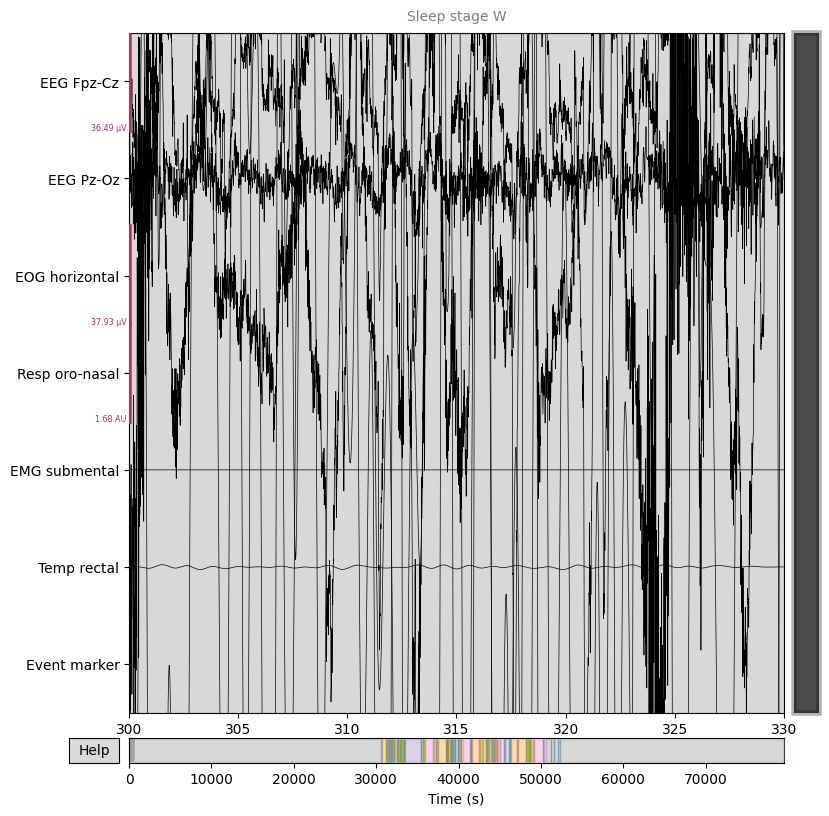

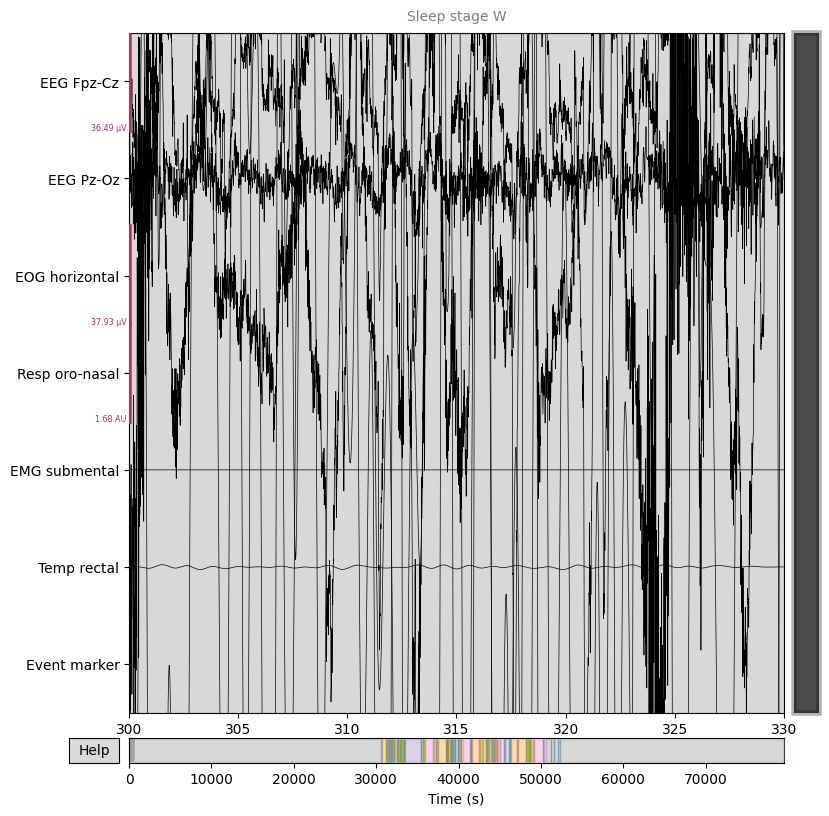

In [ ]:
raw_train.plot(duration = 30, scalings = 'auto', start = 300,clipping=None) # plots some of the raw data for a duration of 30 seconds starting from the 300th second

In [ ]:
#Each recording comes with metadata
print(raw_train.info)

<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 2 EEG, 1 EOG, 4 misc
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>


In [ ]:
sampling_rate = raw_train.info['sfreq']
print('sampling rate = {}'.format(sampling_rate))

sampling rate = 100.0


***PREPARE PHYSIONET***

We define certain methods that will be useful for saving all the sleep recordings into files

In [ ]:

#UTILS
import re, datetime, operator
import numpy as np
from collections import namedtuple
from builtins import str

In [ ]:
EVENT_CHANNELS = 'EDF Annotations'

def tal(tal_str):
  '''Return a list with (onset, duration, annotation) tuples for an EDF+ TAL
  stream.
  '''
  # Below is the explaination Regex function used for the line
  '''
  1. (?P<onset>[+\-]\d+(?:\.\d*)?):

  > (?P<onset>...): This is a named capturing group with the name "onset."
  > [+\-]: This part captures either a plus (+) or a minus (-) sign, indicating the onset's sign.
  > \d+: This captures one or more digits, representing the integer part of the onset.
  > (?:\.\d*)?: This is a non-capturing group that looks for an optional decimal part of the onset. It captures zero or more digits after a decimal point (dot).

  2.  (?:\x15(?P<duration>\d+(?:\.\d*)?))?:

  > (?:...): This is a non-capturing group that makes the entire duration part optional.
  > \x15: This represents the \x15 character in the input string.
  > (?P<duration>...): This is a named capturing group with the name "duration."
  > \d+: This captures one or more digits, representing the integer part of the duration.
  > (?:\.\d*)?: This is a non-capturing group that looks for an optional decimal part of the duration. It captures zero or more digits after a decimal point (dot).

  3. (\x14(?P<annotation>[^\x00]*))?:

  > (\x14...): This part captures the annotation, which starts with the \x14 character in the input string.
  > (?P<annotation>...): This is a named capturing group with the name "annotation."
  > [^\x00]*: This captures zero or more characters that are not the \x00 (null) character. It allows the annotation to include any text that does not contain null characters.

  4. (?:\x14\x00):

  > This part looks for the \x14\x00 sequence in the input string. It seems to be used to terminate an annotation block.
  '''

  '''
  eg: -2.123\x153.456\x14Annotation 1\x14Annotation 2\x00
  1.234\x14Event Start\x00
  5.678\x150.000\x14Event End\x00

  Using the regular expression components, we can parse this TAL string into TAL entries as follows:

  The first TAL entry:

  Onset: -2.123
  Duration: 3.456
  Annotation: ['Annotation 1', 'Annotation 2']
  The second TAL entry:

  Onset: 1.234
  Duration: None (optional)
  Annotation: ['Event Start']
  The third TAL entry:

  Onset: 5.678
  Duration: 0.000 (optional)
  Annotation: ['Event End']
  '''

  # exp = '(?P[+\-]\d+(?:\.\d*)?)' + \
  #   '(?:\x15(?P\d+(?:\.\d*)?))?' + \
  #   '(\x14(?P[^\x00]*))?' + \
  #   '(?:\x14\x00)'
  exp = '(?P<onset>[+\-]\d+(?:\.\d*)?)' + \
    '(?:\x15(?P<duration>\d+(?:\.\d*)?))?' + \
    '(\x14(?P<annotation>[^\x00]*))?' + \
    '(?:\x14\x00)'

  # This is a helper function that takes an annotation string and splits it into a list using the \x14 character as a delimiter. This is used to handle the annotation component.
  def annotation_to_list(annotation):
    return annotation.split('\x14') if annotation else []

  # converts them into a tuple of (onset, duration, annotation). It converts onset and duration to float types, handling cases where duration is not present.
  def parse(dic):
    return(
        float(dic['onset']),
        float(dic['duration']) if dic['duration'] else 0. ,
        annotation_to_list(dic['annotation'])
    )

  # The re.finditer function is used to find all matches of the exp pattern in the tal_str. For each match, the parse function is called to create a tuple, and all tuples are collected in a list.
  return [parse(m.groupdict()) for m in re.finditer(exp, tal_str)]

In [ ]:
def edf_header(f):
  h = {} # Initialize an empty dictionary to store header information.

  assert f.tell() == 0 # Check file position and assert that it's at the beginning (offset 0).
  assert f.read(8) == '0       ' # Assert that the first 8 characters of the file are '0       '

  # Read and store local subject ID (next 80 characters) and local recording ID (80 characters).
  h['local_subject_id'] = f.read(80).strip()
  h['local_recording_id'] = f.read(80).strip()

  # Parse timestamp information (day, month, year, hour, minute, second).
  (day, month, year) = [int(x) for x in re.findall('(\d+)', f.read(8))] # "251021". After applying re.findall, it will find the following matches: ['25', '10', '21'] representing day, month, and year.
  (hour, minute, sec) = [int(x) for x in re.findall('(\d+)', f.read(8))] # "202130", it will find and return the list ['20', '21', '30'] ->  ('20', '21', '30') after applying int

  # Create a 'datetime' object and store it in the 'date_time' field of the dictionary.
  h['date_time'] = str(datetime.datetime(year + 2000, month, day, hour, minute, sec)) # eg: '2021-10-21 20:21:30'

  # Read header information including header nbytes, subtype, EDF+ flag, number of records, record length, and number of channels.
  header_nbytes = int(f.read(8)) # These 8 characters typically represent the total number of bytes in the header section of the EDF file
  subtype = f.read(44)[:5] # 5 characters are expected to represent a subtype within the EDF file, such as 'EDF+C' or 'EDF+D'
  h['EDF+'] = subtype in ['EDF+C', 'EDF+D'] # stores the result (a boolean) in the EDF+
  h['contiguous'] = subtype != 'EDF+D' # checks whether the subtype variable is not equal to 'EDF+D' & checks whether the subtype variable is not equal to 'EDF+D'
  h['n_records'] = int(f.read(8)) # resulting integer is stored in the n_records field of the dictionary h
  h['record_length'] = float(f.read(8))  # Record length in seconds
  nchannels = h['n_channels'] = int(f.read(4)) #  characters typically represent the number of channels (data streams) in the EDF file

  # Read channel-specific information for each channel.
  # This line creates a range of numbers from 0 to h['n_channels'] - 1. The variable channels is used to iterate through each channel's information in the subsequent lines.
  channels = range(h['n_channels'])
  # This line reads 16 characters for each channel's label, strips any leading or trailing whitespace, and stores them in the label field of the dictionary h. This field typically contains labels for each channel (e.g., 'EEG', 'ECG', etc.).
  h['label'] = [f.read(16).strip() for n in channels]
  # h['transducer_type'] = [f.read(80).strip() for n in channels]: Similar to the previous line, this line reads 80 characters for each channel's transducer type, strips any leading or trailing whitespace, and stores them in the transducer_type field. Transducer types describe the sensors or equipment
  h['transducer_type'] = [f.read(80).strip() for n in channels]
  # Units represent the measurement units for the data (e.g., 'uV' for microvolts).
  h['units'] = [f.read(8).strip() for n in channels]
  h['physical_min'] = np.asarray([float(f.read(8)) for n in channels])
  h['physical_max'] = np.asarray([float(f.read(8)) for n in channels])
  h['digital_min'] = np.asarray([float(f.read(8)) for n in channels])
  h['digital_max'] = np.asarray([float(f.read(8)) for n in channels])
  # Prefiltering information describes any filtering applied to the channel's data.
  h['prefiltering'] = [f.read(80).strip() for n in channels]
  # This value indicates how many data points are in each record for each channel.
  h['n_samples_per_record'] = [int(f.read(8)) for n in channels]

  f.read(32 * nchannels)  # reserved

  assert f.tell() == header_nbytes
  return h

In [ ]:
class EDFEndOfData(BaseException): pass

class BaseEDFReader:
  def __init__(self, file):
    self.file = file # This is the constructor method for the class. It takes one argument, file, which is expected to be a file object representing an opened EDF file.

  def read_header(self):
    self.header = h = edf_header(self.file) #  method is responsible for reading and processing the header information of the EDF file

    # calculate ranges for rescaling
    self.dig_min = h['digital_min'] # The digital minimum values for each channel.
    self.phys_min = h['physical_min'] # The physical minimum values for each channel.
    phys_range = h['physical_max'] - h['physical_min'] # The range of physical values (physical_max - physical_min) for each channel.
    dig_range = h['digital_max'] - h['digital_min'] # The range of digital values (digital_max - digital_min) for each channel.
    assert np.all(phys_range > 0) # This assertion checks that all elements in the phys_range array (or NumPy ndarray) are greater than 0.
    assert np.all(dig_range > 0) # This one checks that all elements in the dig_range array are greater than 0.
    self.gain = phys_range / dig_range # The scaling factor (gain) used to convert digital values to physical values. It's calculated as phys_range / dig_range.

  def read_raw_record(self):
    '''Read a record with data and return a list containing arrays with raw
    bytes.
    '''

    result = [] # Initialize an empty list to store the raw data.

    for nsamp in self.header['n_samples_per_record']:
        # Iterate through the number of samples per record for each channel.

        # Read the raw data for this record. The *2 is used because each sample is typically stored as 2 bytes.
        samples = self.file.read(nsamp * 2)

        # Check if the number of bytes read matches the expected length for this record. If not, raise an exception indicating the end of data.
        if len(samples) != nsamp * 2:
          raise EDFEndOfData

        # Append the raw data (byte array) for this record to the result list.
        result.append(samples)

    return result

  def convert_record(self, raw_record):
    '''Convert a raw record to a (time, signals, events) tuple based on
    information in the header.
    '''
    h = self.header
    dig_min, phys_min, gain = self.dig_min, self.phys_min, self.gain
    time = float('nan')  # Initialize the time variable with NaN (Not-a-Number).
    signals = []  # Initialize an empty list to store signal data.
    events = []   # Initialize an empty list to store event data.

    for (i, samples) in enumerate(raw_record):
        if h['label'][i] == EVENT_CHANNELS:
            # Check if the current channel is an event channel.
            ann = tal(samples) # function is used to parse event annotations from the raw data.
            time = ann[0][0]  # Extract the time information from the event annotations.
            events.extend(ann[1:])  # Extend the events list with event annotations (excluding the time).

        else:
            # If the channel is not an event channel, it contains signal data.
            # Convert the raw byte data to numerical values based on scaling factors.
            dig = np.fromstring(samples, dtype=np.int16)
            phys = (dig - dig_min[i]) * gain[i] + phys_min[i] # The numerical values (dig) are then converted to physical values (phys) using the scaling factors (digital minimum, physical minimum, and gain).
            signals.append(phys) #  resulting physical values (phys) are appended to the signals list

    return time, signals, events # time variable represents the time of the data record, signals contains the converted signal data, and events contains any event annotations present in the record.

  def read_record(self):
    return self.convert_record(self.read_raw_record())


  def records(self):
    '''
    Record generator.
    '''
    try:
      while True:
        yield self.read_record()
    except EDFEndOfData:
      pass

***EXTRACTING SLEEP RECORDINGS***

In [ ]:
# replace next variable (input_data_path) with your own path

input_data_path = '/content/gdrive/MyDrive/ML_projects/P2-sleep'

# we iterate over all recordings and subjects
for r in [1,2]: # r = recording, iterates over values [1, 2]
  for i in [i for i in np.arange(20)]: # i = subject,  iterates over values generated using np.arange(20)
    if (i == 13) & (r ==2):
      continue # skips a specific case where i is 13 and r is 2 as recording 2 for subject 13 is not available.


    [s1_files] = fetch_data(subjects=[i], recording=[r]) # The function returns a list [s1_files] containing file paths related to the specified subject and recording.
    select_ch = 'EEG Fpz-Cz' # This line assigns the string 'EEG Fpz-Cz' to the variable select_ch
    print('Files loaded: {} and {}'.format(s1_files[0], s1_files[1])) # prints a message, indicating the file paths loaded for the current subject and recording

    #We generate the object with signal data for each recording
    raw = read_raw_edf(s1_files[0], preload=True, stim_channel=None)
    sampling_rate = raw.info['sfreq']
    raw_ch_df = raw.to_data_frame()[select_ch] #default="EEG Fpz-Cz",
    raw_ch_df = raw_ch_df.to_frame()
    raw_ch_df.set_index(np.arange(len(raw_ch_df)))


    # we obtain the recording's metadata, or header.
    f = open(s1_files[0], 'r', encoding = 'latin_1')
    reader_raw = BaseEDFReader(f)
    reader_raw.read_header()
    h_raw = reader_raw.header
    f.close()
    raw_start_dt = dt.strptime(h_raw['date_time'], "%Y-%m-%d %H:%M:%S")

    f = open(s1_files[1], 'r')
    reader_ann = BaseEDFReader(f)
    reader_ann.read_header()
    h_ann = reader_ann.header

    _, _, ann = zip(*reader_ann.records())
    f.close()
    ann_start_dt = dt.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

    assert raw_start_dt == ann_start_dt


    # Label values
    W = 0
    N1 = 1
    N2 = 2
    N3 = 3
    REM = 4
    UNKNOWN = 5

    stage_dict = { "W": W, "N1": N1, "N2": N2, "N3": N3, "REM": REM, "UNKNOWN": UNKNOWN }
    class_dict = { 0: "W", 1: "N1",  2: "N2", 3: "N3", 4: "REM", 5: "UNKNOWN" }
    ann2label = {  "Sleep stage W": 0, "Sleep stage 1": 1,"Sleep stage 2": 2, "Sleep stage 3": 3,
                "Sleep stage 4": 3,  "Sleep stage R": 4, "Sleep stage ?": 5, "Movement time": 5 }
    EPOCH_SEC_SIZE = 30


    # Vector with indices and labels
    remove_idx = []    # indicies of the data that will be removed
    labels = []        # indicies of the data that have labels
    label_idx = []
    for a in ann[0]:
      onset_sec, duration_sec, ann_char = a
      ann_str = "".join(ann_char)
      label = ann2label[ann_str]
      if label != UNKNOWN:
        if duration_sec % EPOCH_SEC_SIZE != 0:
          raise Exception("Something wrong")
        duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
        label_epoch = np.ones(duration_epoch, dtype=np.int) * label
        labels.append(label_epoch)
        idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
        label_idx.append(idx)

      else:
        idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
        remove_idx.append(idx)

    labels = np.hstack(labels)


    if len(remove_idx) > 0:
      remove_idx = np.hstack(remove_idx)
      select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
    else:
      select_idx = np.arange(len(raw_ch_df))

    # Only valid labels
    label_idx = np.hstack(label_idx)
    select_idx = np.intersect1d(select_idx, label_idx)

     # If necessary, extra indices are removed
    if len(label_idx) > len(select_idx):
        extra_idx = np.setdiff1d(label_idx, select_idx)
        # Vector tail is trimmed
        if np.all(extra_idx > select_idx[-1]):
            n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
            n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
            select_idx = select_idx[:-n_trims]
            labels = labels[:-n_label_trims]


    raw_ch = raw_ch_df.values[select_idx]

    # Vector should be splittable into 30 second periods
    if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
        raise Exception("Something wrong")
    n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

    x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
    y = labels.astype(np.int32)

    assert len(x) == len(y)

    # We keep only section that correspond to sleep.
    w_edge_mins = 30
    nw_idx = np.where(y != stage_dict["W"])[0]
    start_idx = nw_idx[0] - (w_edge_mins * 2) #60  epochs before sleep onset
    end_idx = nw_idx[-1] + (w_edge_mins * 2) # 60 epochs after sleep is finished
    if start_idx < 0: start_idx = 0
    if end_idx >= len(y): end_idx = len(y) - 1
    select2_idx = np.arange(start_idx, end_idx+1)
    raw_datapoint = x.shape[0]
    x = x[select2_idx]
    selected_datapoints = x.shape[0]
    y = y[select2_idx]
    cal =  (raw_datapoint - selected_datapoints )*100/raw_datapoint

    filename = ntpath.basename(s1_files[0]).replace("-PSG.edf", ".npz")
    save_dict = {
        "x": x,
        "y": y,
        "fs": sampling_rate,
        "ch_label": select_ch,
        "header_raw": h_raw,
        "header_annotation": h_ann,
    }



    np.savez(os.path.join(input_data_path, filename), **save_dict)

    print('File {} was processed and saved'.format(s1_files[0]))

    print("\n=======================================\n")

Using default location ~/mne_data for PHYSIONET_SLEEP...
Files loaded: /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

File /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 9.37GB/s]
100%|█████████████████████████████████████| 3.90k/3.90k [00:00<00:00, 2.11MB/s]

Download complete in 48s (48.7 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4011EH-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 33.5GB/s]
100%|█████████████████████████████████████| 4.80k/4.80k [00:00<00:00, 4.72MB/s]

Download complete in 48s (48.8 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4021E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4021EH-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8411999  =      0.000 ... 84119.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4021E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.4M/51.4M [00:00<00:00, 28.6GB/s]
100%|█████████████████████████████████████| 3.70k/3.70k [00:00<00:00, 2.61MB/s]

Download complete in 48s (49.1 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4031E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4031EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8459999  =      0.000 ... 84599.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4031E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 46.9M/46.9M [00:00<00:00, 24.2GB/s]
100%|█████████████████████████████████████| 4.83k/4.83k [00:00<00:00, 3.17MB/s]

Download complete in 45s (44.7 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4041E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4041EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7709999  =      0.000 ... 77099.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4041E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 49.7M/49.7M [00:00<00:00, 33.2GB/s]
100%|█████████████████████████████████████| 3.98k/3.98k [00:00<00:00, 2.82MB/s]

Download complete in 48s (47.4 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4051E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4051EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8165999  =      0.000 ... 81659.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4051E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.5M/50.5M [00:00<00:00, 33.8GB/s]
100%|█████████████████████████████████████| 2.62k/2.62k [00:00<00:00, 2.03MB/s]

Download complete in 48s (48.2 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4061E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4061EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4061E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8309999  =      0.000 ... 83099.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4061E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.3M/51.3M [00:00<00:00, 20.5GB/s]
100%|█████████████████████████████████████| 3.63k/3.63k [00:00<00:00, 2.27MB/s]

Download complete in 54s (48.9 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4071E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4071EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4071E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4071E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.0M/51.0M [00:00<00:00, 16.7GB/s]
100%|█████████████████████████████████████| 4.31k/4.31k [00:00<00:00, 1.65MB/s]

Download complete in 52s (48.6 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4081E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4081EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4081E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8387999  =      0.000 ... 83879.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4081E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 49.8M/49.8M [00:00<00:00, 18.0GB/s]
100%|█████████████████████████████████████| 4.47k/4.47k [00:00<00:00, 2.51MB/s]

Download complete in 49s (47.5 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4091E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4091EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4091E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8195999  =      0.000 ... 81959.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4091E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 49.6M/49.6M [00:00<00:00, 25.4GB/s]
100%|██████████████████████████████████████| 2.22k/2.22k [00:00<00:00, 710kB/s]

Download complete in 50s (47.3 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4101E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4101EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4101E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8159999  =      0.000 ... 81599.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4101E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 48.2M/48.2M [00:00<00:00, 30.7GB/s]
100%|█████████████████████████████████████| 3.88k/3.88k [00:00<00:00, 2.28MB/s]

Download complete in 47s (46.0 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4111E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4111EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4111E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7925999  =      0.000 ... 79259.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4111E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.8M/50.8M [00:00<00:00, 17.3GB/s]
100%|█████████████████████████████████████| 4.01k/4.01k [00:00<00:00, 2.86MB/s]

Download complete in 49s (48.5 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4121E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4121EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4121E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8357999  =      0.000 ... 83579.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4121E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.3M/51.3M [00:00<00:00, 18.7GB/s]
100%|██████████████████████████████████████| 4.44k/4.44k [00:00<00:00, 808kB/s]

Download complete in 50s (49.0 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4131E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4131EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4131E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8441999  =      0.000 ... 84419.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4131E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.3M/50.3M [00:00<00:00, 18.1GB/s]
100%|█████████████████████████████████████| 3.77k/3.77k [00:00<00:00, 2.28MB/s]

Download complete in 46s (47.9 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4141E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4141EU-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4141E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4141E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 47.8M/47.8M [00:00<00:00, 25.8GB/s]
100%|█████████████████████████████████████| 3.16k/3.16k [00:00<00:00, 2.24MB/s]

Download complete in 44s (45.6 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4151E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4151EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4151E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7859999  =      0.000 ... 78599.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4151E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 47.9M/47.9M [00:00<00:00, 18.6GB/s]
100%|█████████████████████████████████████| 4.66k/4.66k [00:00<00:00, 1.63MB/s]

Download complete in 47s (45.7 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4161E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4161EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4161E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7877999  =      0.000 ... 78779.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4161E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.0M/50.0M [00:00<00:00, 21.9GB/s]
100%|█████████████████████████████████████| 5.38k/5.38k [00:00<00:00, 1.59MB/s]

Download complete in 47s (47.7 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4171E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4171EU-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4171E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8225999  =      0.000 ... 82259.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4171E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.3M/50.3M [00:00<00:00, 26.9GB/s]
100%|█████████████████████████████████████| 4.81k/4.81k [00:00<00:00, 1.65MB/s]

Download complete in 46s (47.9 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4181E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4181EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4181E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4181E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.6M/50.6M [00:00<00:00, 20.4GB/s]
100%|█████████████████████████████████████| 5.28k/5.28k [00:00<00:00, 1.32MB/s]

Download complete in 48s (48.3 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4191E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4191EP-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4191E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8321999  =      0.000 ... 83219.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4191E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.6M/51.6M [00:00<00:00, 27.6GB/s]
100%|██████████████████████████████████████| 4.58k/4.58k [00:00<00:00, 777kB/s]

Download complete in 51s (49.2 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4002E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4002EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4002E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 52.0M/52.0M [00:00<00:00, 18.3GB/s]
100%|█████████████████████████████████████| 5.08k/5.08k [00:00<00:00, 1.76MB/s]

Download complete in 50s (49.6 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4012E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4012EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4012E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.3M/50.3M [00:00<00:00, 17.4GB/s]
100%|█████████████████████████████████████| 5.29k/5.29k [00:00<00:00, 2.59MB/s]

Download complete in 46s (47.9 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4022E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4022EJ-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4022E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...
Files loaded: /root/mne_data/physionet-sleep-data/SC4032E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4032EP-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4032E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8195999  =      0.000 ... 81959.990 secs...


<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

File /root/mne_data/physionet-sleep-data/SC4032E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.9M/50.9M [00:00<00:00, 15.9GB/s]
100%|█████████████████████████████████████| 5.28k/5.28k [00:00<00:00, 1.33MB/s]

Download complete in 47s (48.6 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4042E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4042EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4042E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8375999  =      0.000 ... 83759.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4042E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.2M/51.2M [00:00<00:00, 18.2GB/s]
100%|█████████████████████████████████████| 4.23k/4.23k [00:00<00:00, 1.59MB/s]

Download complete in 49s (48.8 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4052E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4052EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4052E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8417999  =      0.000 ... 84179.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4052E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.6M/51.6M [00:00<00:00, 17.4GB/s]
100%|█████████████████████████████████████| 3.15k/3.15k [00:00<00:00, 1.55MB/s]

Download complete in 50s (49.2 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4062E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4062EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4062E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4062E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.5M/50.5M [00:00<00:00, 16.4GB/s]
100%|█████████████████████████████████████| 5.28k/5.28k [00:00<00:00, 2.71MB/s]

Download complete in 47s (48.2 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4072E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4072EH-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4072E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8309999  =      0.000 ... 83099.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4072E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 48.0M/48.0M [00:00<00:00, 16.1GB/s]
100%|█████████████████████████████████████| 4.67k/4.67k [00:00<00:00, 2.14MB/s]

Download complete in 47s (45.8 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4082E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4082EP-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4082E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Reading 0 ... 7901999  =      0.000 ... 79019.990 secs...


<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

File /root/mne_data/physionet-sleep-data/SC4082E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 52.1M/52.1M [00:00<00:00, 19.5GB/s]
100%|█████████████████████████████████████| 3.66k/3.66k [00:00<00:00, 1.41MB/s]

Download complete in 50s (49.7 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4092E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4092EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4092E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8573999  =      0.000 ... 85739.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4092E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 52.1M/52.1M [00:00<00:00, 23.4GB/s]
100%|█████████████████████████████████████| 3.67k/3.67k [00:00<00:00, 1.05MB/s]

Download complete in 49s (49.7 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4102E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4102EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4102E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8573999  =      0.000 ... 85739.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4102E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.7M/50.7M [00:00<00:00, 28.2GB/s]
100%|█████████████████████████████████████| 3.88k/3.88k [00:00<00:00, 2.44MB/s]

Download complete in 48s (48.4 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4112E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4112EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4112E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8339999  =      0.000 ... 83399.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4112E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 47.5M/47.5M [00:00<00:00, 15.8GB/s]
100%|█████████████████████████████████████| 4.51k/4.51k [00:00<00:00, 1.87MB/s]

Download complete in 45s (45.3 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4122E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4122EV-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4122E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7817999  =      0.000 ... 78179.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4122E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.6M/50.6M [00:00<00:00, 30.2GB/s]
100%|█████████████████████████████████████| 3.83k/3.83k [00:00<00:00, 1.54MB/s]

Download complete in 51s (48.3 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4142E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4142EU-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4142E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8321999  =      0.000 ... 83219.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4142E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 52.2M/52.2M [00:00<00:00, 17.9GB/s]
100%|█████████████████████████████████████| 3.39k/3.39k [00:00<00:00, 1.27MB/s]

Download complete in 46s (49.8 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4152E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4152EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4152E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8591999  =      0.000 ... 85919.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4152E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.2M/50.2M [00:00<00:00, 13.8GB/s]
100%|█████████████████████████████████████| 4.12k/4.12k [00:00<00:00, 2.09MB/s]

Download complete in 47s (47.9 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4162E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4162EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4162E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8255999  =      0.000 ... 82559.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4162E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 49.7M/49.7M [00:00<00:00, 16.2GB/s]
100%|██████████████████████████████████████| 5.56k/5.56k [00:00<00:00, 987kB/s]

Download complete in 47s (47.4 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4172E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4172EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4172E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8171999  =      0.000 ... 81719.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4172E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.8M/51.8M [00:00<00:00, 15.2GB/s]
100%|██████████████████████████████████████| 3.41k/3.41k [00:00<00:00, 851kB/s]

Download complete in 48s (49.4 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4182E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4182EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4182E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8525999  =      0.000 ... 85259.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4182E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 47.6M/47.6M [00:00<00:00, 17.1GB/s]
100%|█████████████████████████████████████| 3.95k/3.95k [00:00<00:00, 1.57MB/s]

Download complete in 43s (45.4 MB)
Files loaded: /root/mne_data/physionet-sleep-data/SC4192E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4192EV-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4192E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7829999  =      0.000 ... 78299.990 secs...



<ipython-input-18-5d163436b9ff>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_epoch = np.ones(duration_epoch, dtype=np.int) * label
<ipython-input-18-5d163436b9ff>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

File /root/mne_data/physionet-sleep-data/SC4192E0-PSG.edf was processed and saved




In [ ]:
# Make sure to have the GPU active!

print(tf.__version__)

print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.15.0
Number of GPUs Available:  1
Found GPU at: /device:GPU:0


***Load Functions***

In [ ]:
d = np.load('/content/gdrive/MyDrive/ML_projects/P2-sleep/SC4001E0.npz')
arr3 = d['y']
arr1 = d['fs']
arr2 = d['x']
print(arr3)
print(arr1)
print(arr2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 2 2 3 3 3 3 3 3 3
 3 3 3 2 2 2 2 2 2 2 3 2 2 3 3 3 3 1 2 2 2 2 2 3 3 2 3 2 3 3 3 3 3 3 3 3 3
 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3
 3 3 3 3 3 2 2 3 3 3 2 2 2 2 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 1 1 1 1 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 3 3 3 3 3 3 3 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 2
 2 1 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 2 1 1 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 2 3 2 3 3 3 3 3 3 3 

In [ ]:
def load_npz_file(npz_file):
  ''' Load data and labels from npz file '''
  with np.load(npz_file) as f:
    data = f['x']
    labels = f['y']
    sampling_rate = f['fs']

    return data, labels, sampling_rate

def load_npz_list_files(npz_files):
  data = [] # This line initializes an empty list to store the data arrays from each NPZ file.
  labels = [] # This line initializes an empty list to store the label arrays from each NPZ file.
  fs = None # This line initializes a variable fs to None to store the sampling rate. It will be used to check for consistency among NPZ files.

  for npz_f in npz_files: # This line starts a loop that iterates through each NPZ file in the provided list.
    tmp_data, tmp_labels, sampling_rate = load_npz_file(npz_f) # This line calls the load_npz_file function to load data, labels, and sampling rate from the current NPZ file in the loop.

    if fs is None: # This line checks if fs is still None, indicating that it hasn't been set yet.
      fs = sampling_rate
    elif fs != sampling_rate:
      raise Exception("Found mismatch in sampling rate.")  # If fs is not None and there's a mismatch in sampling rate, this line raises an exception.
    data.append(tmp_data) # This line appends the data array from the current NPZ file to the data list.
    labels.append(tmp_labels) # This line appends the label array from the current NPZ file to the labels list.

  data = np.vstack(data) # This line vertically stacks the data arrays from all NPZ files into a single array.
  labels = np.hstack(labels) # This line horizontally stacks the label arrays from all NPZ files into a single array.
  return data, labels

***Reading of recordings***

In [ ]:
r_path = '/content/gdrive/MyDrive/ML_projects/P2-sleep'

files = os.listdir(r_path)
filespath = []
for i in files:
  _, file_extension = os.path.splitext(i)
  print(_)
  if file_extension.lower() == '.npz':
    # print(i)
    filespath.append(os.path.join(r_path, i))
print(filespath)
print(len(filespath))
x, y = load_npz_list_files(filespath)
print(x.shape)
x = x.reshape(x.shape[0], x.shape[1], 1)
print(x.shape, y.shape)

SC4001E0
SC4011E0
SC4021E0
SC4031E0
SC4041E0
SC4051E0
SC4061E0
SC4071E0
SC4081E0
SC4091E0
SC4101E0
SC4111E0
SC4121E0
SC4131E0
SC4141E0
SC4151E0
SC4161E0
SC4171E0
SC4181E0
SC4191E0
SC4002E0
SC4012E0
SC4022E0
SC4032E0
SC4042E0
SC4052E0
SC4062E0
SC4072E0
SC4082E0
SC4092E0
SC4102E0
SC4112E0
SC4122E0
SC4142E0
SC4152E0
SC4162E0
SC4172E0
SC4182E0
SC4192E0
dualcnn_bilstm
dualcnn_attn_bilstm
one_data_cnn_att
['/content/gdrive/MyDrive/ML_projects/P2-sleep/SC4001E0.npz', '/content/gdrive/MyDrive/ML_projects/P2-sleep/SC4011E0.npz', '/content/gdrive/MyDrive/ML_projects/P2-sleep/SC4021E0.npz', '/content/gdrive/MyDrive/ML_projects/P2-sleep/SC4031E0.npz', '/content/gdrive/MyDrive/ML_projects/P2-sleep/SC4041E0.npz', '/content/gdrive/MyDrive/ML_projects/P2-sleep/SC4051E0.npz', '/content/gdrive/MyDrive/ML_projects/P2-sleep/SC4061E0.npz', '/content/gdrive/MyDrive/ML_projects/P2-sleep/SC4071E0.npz', '/content/gdrive/MyDrive/ML_projects/P2-sleep/SC4081E0.npz', '/content/gdrive/MyDrive/ML_projects/P2-sleep/S

In [ ]:
# !pip install keras_self_attention
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json, load_model
from keras.layers import Dense, Embedding, LSTM, Reshape, Bidirectional
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D, MaxPooling2D
# from keras.utils import np_utils
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense, TimeDistributed)
# from keras_self_attention import SeqSelfAttention
from tensorflow.keras.utils import to_categorical, custom_object_scope
import tensorflow as tf
from tensorflow.keras import layers
#tf.keras.layers.Attention
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Input, Dense, Flatten, BatchNormalization, Dropout, ReLU, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import StratifiedKFold
from datetime import datetime as dt
import numpy as np
from tensorflow.keras import layers  # Added import

In [ ]:
def dual_cnn(input_length = 3000):
  input_length = input_length

  inputs = keras.Input(shape = (input_length, 1))

  # Left leg
  x = layers.Conv1D(filters = 64, kernel_size = 50, strides = 6, name = 'conv1')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.MaxPool1D(pool_size = 8, strides = 8, name = 'max_pool1')(x)

  x = layers.Dropout(rate = 0.5, name = 'drouput1')(x)

  x = layers.Conv1D(filters = 128, kernel_size = 8, strides = 1, padding = 'same', name = 'conv2')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv1D(filters = 128, kernel_size = 8, strides = 1, padding = 'same', name = 'conv3')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv1D(filters = 128, kernel_size = 8, strides = 1, padding = 'same', name = 'conv4')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.MaxPool1D(pool_size = 4, strides = 4, name = 'max_pool2')(x)
  x = layers.Flatten()(x)

  # Right leg
  x2 = layers.Conv1D(filters = 64, kernel_size = 400, strides = 50, name = 'conv1_2')(inputs)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.MaxPool1D(pool_size = 4, strides = 4, name = 'max_pool1_2')(x2)

  x2 = layers.Dropout(rate = 0.5, name = 'drouput1_2')(x2)

  x2 = layers.Conv1D(filters = 128, kernel_size = 6, strides = 1, padding = 'same', name = 'conv2_2')(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.Conv1D(filters = 128, kernel_size = 6, strides = 1, padding = 'same', name = 'conv3_2')(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.Conv1D(filters = 128, kernel_size = 6, strides = 1, padding = 'same', name = 'conv4_2')(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.MaxPool1D(pool_size = 2, strides = 2, name = 'max_pool2_2')(x2)
  x2 = layers.Flatten()(x2)

  #Concat
  concat = layers.Concatenate(name = 'concat1')([x, x2])

  #Final layer
  outputs = layers.Dense(5, activation = tf.nn.softmax, name = 'soft')(concat)

  model = keras.Model(inputs=inputs, outputs=outputs, name='sleep')

  return model

In [ ]:
def lstm_model():
  # input_shape=(5, 2688)
  inputs = keras.Input(shape = (5, 2688))

  x = layers.Dropout(rate = 0.5, name = 'lstm_dropout1')(inputs)

  x1 = tf.keras.layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
  x1 = layers.Dropout(rate = 0.5, name = 'lstm_dropout2')(x1)

  x1 = tf.keras.layers.Bidirectional(layers.LSTM(512))(x1)
  x1 = layers.Dropout(rate = 0.5, name = 'lstm_dropout3')(x1)

  x2 = layers.Dense(1024)(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU(name = 'lstm_residual1')(x2)

  add = layers.Add(name = 'add1')([x1, x2])

  x3 = layers.BatchNormalization()(add)
  x3 = layers.ReLU(name = 'lstm_residual2')(x3)

  x3 = layers.Dropout(rate = 0.5, name = 'lstm_droput4')(x3)
  x3 = layers.Flatten()(x3)

  #Final layer
  outputs = layers.Dense(5, activation = tf.nn.softmax, name = 'lstm_soft')(x3)
  model_lstm = keras.Model(inputs=inputs, outputs=outputs, name='lstm_sleep')

  return model_lstm

In [ ]:
# def train_and_predict(X, Y, n_splits):

#   # Define the no.of folds for stratified k-fold cross validation
#   n_splits = n_splits
#   skf = StratifiedKFold(n_splits = n_splits)

#   # Initialize an empty list to store cross-validation results
#   cv_results = []

#   # Initialize counter for k fold
#   k = 0

#   # Loop over stratified k folds
#   for train_i, test_i in skf.split(X, Y):
#     # Record the start time for current fold
#     begin_time_loop = dt.now()
#     print('Current time: {}'.format(str(begin_time_loop)))

#     k = k + 1 # Increment fold counter
#     X_train, X_test = X[train_i], X[test_i] # Split the data into training and testing sets for inputs
#     Y_train, Y_test = Y[train_i], Y[test_i] # Split the data into testing and testing sets for outputs

#     ## Dual Channel CNN
#     model_dual = dual_cnn()
#     model_dual.compile(
#         loss = keras.losses.SparseCategoricalCrossentropy(),
#         optimizer = keras.optimizers.Adam(learning_rate = 0.001),
#         metrics = ['accuracy']
#     ) # Compile the CNN model with specified loss function, optimizer, and metrics.

#     history_dual = model_dual.fit(X_train, Y_train, batch_size = 100, epochs = 3, verbose = 0)

#     # Get feature vectors
#     layer_name = 'concat1'
#     # Creates a new model (intermediate_layer_model) that takes the same input as the original model but outputs the intermediate layer named 'concat'
#     intermediate_layer_model = keras.Model(inputs = model_dual.input, outputs = model_dual.get_layer(layer_name).output)
#     intermediate_output_train = intermediate_layer_model.predict(X_train) # This method is used to obtain predictions (feature vectors) from the specified intermediate layer for the given input data
#     intermediate_output_test = intermediate_layer_model.predict(X_test) # This method is used to obtain predictions (feature vectors) from the specified intermediate layer for the given input data

#     # Ensure the shape is compatible with lstm input
#     a = np.zeros((1, 2688))

#     # Rows of zeros are inserted at the beginning ([0, 0]) and end ([-1, -1]) of the feature vectors obtained from the training dataset
#     X_train_lstm = np.insert(intermediate_output_train, [0, 0, -1, -1], a, axis=0) # Adding padding to the intermediate_output_train
#     X_test_lstm = np.insert(intermediate_output_test, [0, 0, -1, -1], a, axis=0) # Adding padding to the intermediate_output_test

#     X_train_lstm2 = [X_train_lstm[i - 2:i + 3] for i in range(2, len(X_train_lstm) - 2)] # Create sequences of 5 feature vectors with padding, starting from index 2 to avoid out-of-bounds error (zero padding)
#     X_test_lstm2 = [X_test_lstm[i - 2:i + 3] for i in range(2, len(X_test_lstm) - 2)]

#     X_train_lstm3 = np.array(X_train_lstm2)
#     X_test_lstm3 = np.array(X_test_lstm2)

#     # LSTM
#     model_lstm = lstm()
#     model_lstm.compile(
#         loss=keras.losses.SparseCategoricalCrossentropy(),
#         optimizer=keras.optimizers.Adam(learning_rate=0.001),
#         metrics=['accuracy']
#     )

#     history_lstm = model_lstm.fit(X_train_lstm, Y_train, batch_size = 100, epochs = 3, verbose = 0)

#     test_scores = model_lstm.evaluate(X_test_lstm3, Y_test, verbose = 1)
#     print('test accuracy', test_scores[1])

#     Y_prob = model_lstm.predict(X_test_lstm3) # predicts the class probabilities for each test data point

#     Y_pred = Y_prob.argmax(axis = -1) # converts the probabilities to predicted classes. Axis=-1 ensures that the argmax function finds the most likely class for each data point individually

#     elapsed = dt.now() - begin_time_loop
#     print('Fold {} took {}'.format(str(k), str(elapsed))) # calculates the time taken for this fold of the cross-validation

#     fold_result = {
#       'fold': k,
#       'time': elapsed,
#       'y_test': Y_test,
#       'y_pred': Y_pred,
#       'y_prob': Y_prob,
#       'history_cnn': history_dual.history,
#       'history_lstm': history_lstm.history,
#       'accuracy': test_scores[1]
#     }

#     cv_results.append(fold_result)

#   return cv_results

In [ ]:
# Function to perform training and prediction for 20 stratified folds
def train_and_predict(X, Y, n_splits=3):
  skf = StratifiedKFold(n_splits=n_splits)
  cv_results = []
  k = 0

  for train_index, test_index in skf.split(X, Y):
      begin_time_loop = dt.now()
      # print('Current time: {}'.format(str(begin_time_loop)))

      k = k + 1
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = Y[train_index], Y[test_index]

      # CNN
      model = dual_cnn()
      model.compile(
          loss=keras.losses.SparseCategoricalCrossentropy(),
          optimizer=keras.optimizers.Adam(learning_rate=0.001),
          metrics=['accuracy']
      )

      history1 = model.fit(X_train, y_train, batch_size=100, epochs= 3, verbose=0)

      # Get feature vectors
      layer_name = 'concat1' # holds the name of the intermediate layer from which we want to extract feature vectors.
      intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output) # This function is used to create a new Keras model (intermediate_layer_model) that shares the same input as the original model (model) but produces the output of the specified intermediate layer ('concat')
      intermediate_output_train = intermediate_layer_model.predict(X_train)
      intermediate_output_test = intermediate_layer_model.predict(X_test)

      # Ensure the shape is compatible with the LSTM input
      a = np.zeros((1, 2688))

      X_train_lstm = np.insert(intermediate_output_train, [0, 0, -1, -1], a, axis=0)
      X_test_lstm = np.insert(intermediate_output_test, [0, 0, -1, -1], a, axis=0)

      X_train_lstm2 = [X_train_lstm[i - 2:i + 3] for i in range(2, len(X_train_lstm) - 2)]
      X_test_lstm2 = [X_test_lstm[i - 2:i + 3] for i in range(2, len(X_test_lstm) - 2)]

      X_train_lstm3 = np.array(X_train_lstm2)
      X_test_lstm3 = np.array(X_test_lstm2)

      # LSTM
      lstm = lstm_model()
      lstm.compile(
          loss=keras.losses.SparseCategoricalCrossentropy(),
          optimizer=keras.optimizers.Adam(learning_rate=0.001),
          metrics=['accuracy']
      )

      history2 = lstm.fit(X_train_lstm3, y_train, batch_size=100, epochs=3, verbose=0)

      test_scores = lstm.evaluate(X_test_lstm3, y_test, verbose=1)
      print('Test accuracy:', test_scores[1])

      y_prob = lstm.predict(X_test_lstm3)

      y_pred = y_prob.argmax(axis=-1)

      elapsed = dt.now() - begin_time_loop
      print('Fold {} took {}'.format(str(k), str(elapsed)))

      fold_result = {
          'fold': k,
          'time': elapsed,
          'y_test': y_test,
          'y_pred': y_pred,
          'y_prob': y_prob,
          'history_cnn': history1.history,
          'history_lstm': history2.history,
          'accuracy': test_scores[1]
      }

      cv_results.append(fold_result)

  return cv_results


In [ ]:
cv_results = train_and_predict(x, y, n_splits=3)

441/441 [==============================] - 5s 8ms/step - loss: 0.7205 - accuracy: 0.8423
Test accuracy: 0.8423030376434326
441/441 [==============================] - 5s 8ms/step
Fold 1 took 0:01:44.130990
441/441 [==============================] - 5s 8ms/step - loss: 0.3923 - accuracy: 0.8603
Test accuracy: 0.8603134155273438
441/441 [==============================] - 5s 8ms/step
Fold 2 took 0:01:40.333956
441/441 [==============================] - 5s 8ms/step - loss: 0.7701 - accuracy: 0.8240
Test accuracy: 0.8239966034889221
441/441 [==============================] - 4s 7ms/step
Fold 3 took 0:01:23.328554


In [ ]:
import pickle

path = '/content/gdrive/MyDrive/ML_projects/P2-sleep/dualcnn_bilstm.pkl'

with open(path, 'wb') as f:
    pickle.dump(cv_results, f)

# unravel y_pred and y_test into unique vectors for classification report
y_pred=[]
y_test=[]
for i in cv_results:
  y_pred.extend(i['y_pred'])
  y_test.extend(i['y_test'])

print(classification_report(y_test,y_pred, digits=4) )

              precision    recall  f1-score   support

           0     0.8115    0.9267    0.8653      8285
           1     0.5054    0.3342    0.4023      2804
           2     0.9114    0.8588    0.8843     17799
           3     0.8693    0.8804    0.8748      5703
           4     0.7947    0.8696    0.8305      7717

    accuracy                         0.8422     42308
   macro avg     0.7784    0.7739    0.7714     42308
weighted avg     0.8379    0.8422    0.8375     42308



In [ ]:
def lstm_model():
  # input_shape=(5, 2688)
  inputs = keras.Input(shape = (5, 2688))

  x = layers.Dropout(rate = 0.5, name = 'lstm_dropout1')(inputs)

  x1 = tf.keras.layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
  x1 = layers.Dropout(rate = 0.5, name = 'lstm_dropout2')(x1)

  x1 = tf.keras.layers.Bidirectional(layers.LSTM(512))(x1)
  x1 = layers.Dropout(rate = 0.5, name = 'lstm_dropout3')(x1)

  x2 = layers.Dense(1024)(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU(name = 'lstm_residual1')(x2)

  add = layers.Add(name = 'add1')([x1, x2])

  x3 = layers.BatchNormalization()(add)
  x3 = layers.ReLU(name = 'lstm_residual2')(x3)

  x3 = layers.Dropout(rate = 0.5, name = 'lstm_droput4')(x3)
  x3 = layers.Flatten()(x3)

  #Final layer
  outputs = layers.Dense(5, activation = tf.nn.softmax, name = 'lstm_soft')(x3)
  model_lstm = keras.Model(inputs=inputs, outputs=outputs, name='lstm_sleep')

  return model_lstm

***With Attention***

In [ ]:
class AttentionLayer(layers.Layer):
  def __init__(self, **kwargs): # **kwargs, which allows passing any number of keyword arguments to the initializer
    # Initialize the AttentionLayer class inheriting from the layers.Layer class.
    super(AttentionLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    # Define the weights of the attention layer during the model building phase.
    # Weights are initialized as normal distribution for 'att_weight' and zeros for 'att_bias'
    self.W = self.add_weight(name = 'att_weight', shape = (input_shape[-1], 1), initializer = 'normal')


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def attention_lstm_model():
  # input_shape=(5, 2688)
  inputs = keras.Input(shape=(5, 2688))

  x = layers.Dropout(rate=0.5, name='lstm_dropout1')(inputs)

  x1 = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
  x1 = layers.Dropout(rate=0.5, name='lstm_dropout2_1')(x1)

  x1 = layers.Bidirectional(layers.LSTM(512))(x1)
  x1 = layers.Dropout(rate=0.5, name='lstm_dropout3_1')(x1)

  x2 = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x1)
  x2 = layers.Dropout(rate=0.5, name='lstm_dropout2_2')(x2)

  x2 = layers.Bidirectional(layers.LSTM(512))(x2)
  x2 = layers.Dropout(rate=0.5, name='lstm_dropout3_2')(x2)

  x3 = layers.Dense(1024)(x1)  # Connect to x1, not x
  x3 = layers.BatchNormalization()(x3)
  x3 = layers.ReLU(name='lstm_residual1')(x3)

  add = layers.Add(name='add1')([x2, x3])

  x4 = layers.BatchNormalization()(add)
  x4 = layers.ReLU(name='lstm_residual2')(x4)

  x4 = layers.Dropout(rate=0.5, name='lstm_dropout4')(x4)
  x4 = layers.Flatten()(x4)

  # Final layer
  outputs = layers.Dense(5, activation=tf.nn.softmax, name='lstm_soft')(x4)
  model_lstm = keras.Model(inputs=inputs, outputs=outputs, name='lstm_sleep')

  return model_lstm

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def attention_lstm_model():
    # input_shape=(5, 2688)
    inputs = keras.Input(shape=(5, 2688))

    x = layers.Dropout(rate=0.5, name='lstm_dropout1')(inputs)

    x1 = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
    x1 = layers.Dropout(rate=0.5, name='lstm_dropout2_1')(x1)

    x1 = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x1)
    x1 = layers.Dropout(rate=0.5, name='lstm_dropout3_1')(x1)

    # Attention mechanism
    attention = layers.Dense(1, activation='tanh')(x1)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(1024)(attention)
    attention = layers.Permute([2, 1])(attention)
    attention = layers.Multiply()([x1, attention])
    x1 = layers.Lambda(lambda x: tf.reduce_sum(x, axis=-2))(attention)

    x3 = layers.Dense(1024)(x1)  # Connect to x1, not x
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.ReLU(name='lstm_residual1')(x3)

    add = layers.Add(name='add1')([x1, x3])

    x4 = layers.BatchNormalization()(add)
    x4 = layers.ReLU(name='lstm_residual2')(x4)

    x4 = layers.Dropout(rate=0.5, name='lstm_dropout4')(x4)
    x4 = layers.Flatten()(x4)

    # Final layer
    outputs = layers.Dense(5, activation=tf.nn.softmax, name='lstm_soft')(x4)
    model_lstm = keras.Model(inputs=inputs, outputs=outputs, name='lstm_sleep')

    return model_lstm


In [ ]:
  def attention_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)

    # # Score calculation
    # # A Dense layer computes a score for each time step in the sequence.
    # attention_scores = layers.Dense(1, activation='tanh')(inputs)

    # # Normalization
    # # The scores for each time step are normalized across the time steps using a softmax function, turning them into weights that sum up to 1.
    # attention_weights = layers.Softmax(axis = 1)(attention_scores)

    query = layers.Dense(128, activation='tanh')(inputs)
    attention_scores = layers.Dense(1, activation='softmax', kernel_initializer='glorot_uniform')(query)

    # Context Vector Calculation
    # The original sequence (inputs) and the attention weights are element-wise multiplied.
    context_vector = layers.multiply([inputs, attention_scores])

    # Summing over the time steps to create a single context vector per sample.
    # This vector is a weighted sum of the sequence features, focusing on the most relevant parts.
    context_vector = layers.Lambda(lambda x: tf.reduce_sum(x, axis = 1))(context_vector)

    context_vector = tf.expand_dims(context_vector, axis=1)

    return context_vector

In [ ]:
# def attn_bi_lstm_model():
#   # input_shape=(5, 2688)
#   inputs = keras.Input(shape = (5, 2688))

#   x = layers.Dropout(rate = 0.5, name = 'lstm_dropout1')(inputs)

#   # First Bidirectional LSTM layer with return_sequences=True to keep the time dimension
#   x1 = tf.keras.layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
#   x1 = layers.Dropout(rate = 0.5, name = 'lstm_dropout2')(x1)

#   # Apply attention mechanism on the output of the first Bidirectional LSTM layer
#   x1_attention = attention_block(x1)

#   # Second Bidirectional LSTM layer processes the output of the attention block
#   x1 = tf.keras.layers.Bidirectional(layers.LSTM(512))(x1_attention)
#   x1 = layers.Dropout(rate = 0.5, name = 'lstm_dropout3')(x1)

#   # Parallel Dense layer processing the original input for residual connection
#   x2 = layers.Dense(1024)(x)
#   x2 = layers.BatchNormalization()(x2)
#   x2 = layers.ReLU(name = 'lstm_residual1')(x2)

#   # Add the outputs of the second LSTM and the parallel Dense layer
#   add = layers.Add(name = 'add1')([x1, x2])

#   x3 = layers.BatchNormalization()(add)
#   x3 = layers.ReLU(name = 'lstm_residual2')(x3)

#   x3 = layers.Dropout(rate = 0.5, name = 'lstm_droput4')(x3)
#   x3 = layers.Flatten()(x3)

#   #Final layer
#   outputs = layers.Dense(5, activation = tf.nn.softmax, name = 'lstm_soft')(x3)
#   model_attn_lstm = keras.Model(inputs=inputs, outputs=outputs, name='lstm_sleep')

#   return model_attn_lstm

In [ ]:
  def attn_bi_lstm_model():
    # input_shape=(5, 2688)
    inputs = keras.Input(shape = (5, 2688))

    x = layers.Dropout(rate = 0.3, name = 'lstm_dropout1')(inputs)

    # First Bidirectional LSTM layer with return_sequences=True to keep the time dimension
    x1 = tf.keras.layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x1 = layers.Dropout(rate = 0.3, name = 'lstm_dropout2')(x1)

    # Apply attention mechanism on the output of the first Bidirectional LSTM layer
    x1_attention = attention_block(x1)

    # Second Bidirectional LSTM layer processes the output of the attention block
    x1 = tf.keras.layers.Bidirectional(layers.LSTM(256))(x1_attention)
    x1 = layers.Dropout(rate = 0.5, name = 'lstm_dropout3')(x1)

    # Parallel Dense layer processing the original input for residual connection
    x2 = layers.Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(x) # L2 regularization
    x2 = layers.BatchNormalization()(x2)

    # Add the outputs of the second LSTM and the parallel Dense layer
    add = layers.Add(name = 'add1')([x1, x2])

    x3 = layers.BatchNormalization()(add)
    x3 = layers.ReLU(name = 'lstm_residual2')(x3)

    x3 = layers.Dropout(rate = 0.5, name = 'lstm_droput4')(x3)
    x3 = layers.Flatten()(x3)

    #Final layer
    outputs = layers.Dense(5, activation = tf.nn.softmax, name = 'attn_bi_lstm_soft')(x3)
    model_attn_lstm = keras.Model(inputs=inputs, outputs=outputs, name='attn_bi_lstm_sleep')

    return model_attn_lstm

In [ ]:
# Function to perform training and prediction for 20 stratified folds
def train_and_predict_attn(X, Y, n_splits=3):
  skf = StratifiedKFold(n_splits=n_splits)
  cv_results = []
  k = 0

  for train_index, test_index in skf.split(X, Y):
      begin_time_loop = dt.now()
      # print('Current time: {}'.format(str(begin_time_loop)))

      k = k + 1
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = Y[train_index], Y[test_index]

      # CNN
      model = dual_cnn()
      model.compile(
          loss=keras.losses.SparseCategoricalCrossentropy(),
          optimizer=keras.optimizers.Adam(learning_rate=0.001),
          metrics=['accuracy']
      )

      history1 = model.fit(X_train, y_train, batch_size=100, epochs= 10, verbose=0)

      # Get feature vectors
      layer_name = 'concat1' # holds the name of the intermediate layer from which we want to extract feature vectors.
      intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output) # This function is used to create a new Keras model (intermediate_layer_model) that shares the same input as the original model (model) but produces the output of the specified intermediate layer ('concat')
      intermediate_output_train = intermediate_layer_model.predict(X_train)
      intermediate_output_test = intermediate_layer_model.predict(X_test)

      # Ensure the shape is compatible with the LSTM input
      a = np.zeros((1, 2688))

      X_train_lstm = np.insert(intermediate_output_train, [0, 0, -1, -1], a, axis=0)
      X_test_lstm = np.insert(intermediate_output_test, [0, 0, -1, -1], a, axis=0)

      X_train_lstm2 = [X_train_lstm[i - 2:i + 3] for i in range(2, len(X_train_lstm) - 2)]
      X_test_lstm2 = [X_test_lstm[i - 2:i + 3] for i in range(2, len(X_test_lstm) - 2)]

      X_train_lstm3 = np.array(X_train_lstm2)
      X_test_lstm3 = np.array(X_test_lstm2)

      # attn_bi_lstm
      attn_bi_lstm = attn_bi_lstm_model()
      attn_bi_lstm.compile(
          loss=keras.losses.SparseCategoricalCrossentropy(),
          optimizer=keras.optimizers.Adam(learning_rate=0.001),
          metrics=['accuracy']
      )

      history2 = attn_bi_lstm.fit(X_train_lstm3, y_train, batch_size=100, epochs=5, verbose=0)

      test_scores = attn_bi_lstm.evaluate(X_test_lstm3, y_test, verbose=1)
      print('Test accuracy:', test_scores[1])

      y_prob = attn_bi_lstm.predict(X_test_lstm3)

      y_pred = y_prob.argmax(axis=-1)

      elapsed = dt.now() - begin_time_loop
      print('Fold {} took {}'.format(str(k), str(elapsed)))

      fold_result = {
          'fold': k,
          'time': elapsed,
          'y_test': y_test,
          'y_pred': y_pred,
          'y_prob': y_prob,
          'history_cnn': history1.history,
          'history_attn_bi_lstm': history2.history,
          'accuracy': test_scores[1]
      }

      cv_results.append(fold_result)

  return cv_results


In [ ]:
cv_results_attn = train_and_predict_attn(x, y, n_splits=3)

441/441 [==============================] - 6s 10ms/step - loss: 0.8443 - accuracy: 0.8317
Test accuracy: 0.8316670060157776
441/441 [==============================] - 4s 6ms/step
Fold 1 took 0:02:46.359313
441/441 [==============================] - 5s 8ms/step - loss: 0.6676 - accuracy: 0.7965
Test accuracy: 0.7964972257614136
441/441 [==============================] - 4s 6ms/step
Fold 2 took 0:02:09.465284
441/441 [==============================] - 5s 9ms/step - loss: 0.6006 - accuracy: 0.8350
Test accuracy: 0.8349879384040833
441/441 [==============================] - 4s 7ms/step
Fold 3 took 0:01:55.921722


In [ ]:
import pickle

path = '/content/gdrive/MyDrive/ML_projects/P2-sleep/dualcnn_attn_bilstm.pkl'

with open(path, 'wb') as f:
    pickle.dump(cv_results_attn, f)

# unravel y_pred and y_test into unique vectors for classification report
y_pred=[]
y_test=[]
for i in cv_results_attn:
  y_pred.extend(i['y_pred'])
  y_test.extend(i['y_test'])

print(classification_report(y_test,y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8154    0.9126    0.8613      8285
           1     0.3355    0.4622    0.3888      2804
           2     0.8990    0.8565    0.8773     17799
           3     0.8513    0.9244    0.8863      5703
           4     0.8906    0.6950    0.7807      7717

    accuracy                         0.8211     42308
   macro avg     0.7584    0.7701    0.7589     42308
weighted avg     0.8373    0.8211    0.8254     42308



In [ ]:
# import pickle

# with open('/content/gdrive/MyDrive/ML_projects/P2-sleep/dualcnn_attn_bilstm.pkl', 'rb') as f:

#   data = pickle.load(f)

EOFError: Ran out of input

In [ ]:
# import pickle

# file_path = '/content/gdrive/MyDrive/ML_projects/P2-sleep/dualcnn_attn_bilstm.pkl'

# try:
#     with open(file_path, 'rb') as file:
#         d = pickle.load(file)
#     # After successful loading, you can work with the data in 'd'.
# except EOFError:
#     print("The file is empty or corrupted.")
# except FileNotFoundError:
#     print(f"No file found at {file_path}.")
# except Exception as e:
#     print(f"An unexpected error occurred: {e}")


The file is empty or corrupted.


In [ ]:
# import pickle

# # Sample data
# data_to_save = {'key': 'value'}

# # Saving the data to a pickle file
# try:
#     with open('/content/gdrive/MyDrive/ML_projects/P2-sleep/dualcnn_attn_bilstm.pkl', 'wb') as file:
#         pickle.dump(data_to_save, file)
#     print("Data saved successfully.")
# except Exception as e:
#     print(f"An error occurred while saving the file: {e}")

Data saved successfully.


In [ ]:
import pickle

file_path = '/content/gdrive/MyDrive/ML_projects/P2-sleep/dualcnn_bilstm.pkl'

try:
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    # After successful loading, you can work with the data in 'd'.
except EOFError:
    print("The file is empty or corrupted.")
except FileNotFoundError:
    print(f"No file found at {file_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
data

[{'fold': 1,
  'time': datetime.timedelta(seconds=104, microseconds=130990),
  'y_test': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  'y_pred': array([0, 0, 0, ..., 0, 0, 0]),
  'y_prob': array([[1.00000000e+00, 2.10565699e-14, 3.18616271e-15, 1.29772768e-18,
          2.23951467e-15],
         [1.00000000e+00, 6.14897504e-20, 1.99237525e-22, 3.58122698e-26,
          4.08008485e-20],
         [1.00000000e+00, 1.05577515e-23, 1.06569355e-29, 1.67498982e-32,
          3.70669562e-26],
         ...,
         [9.99999404e-01, 1.67748155e-07, 3.07502190e-10, 6.45309986e-11,
          4.39759901e-07],
         [9.99998689e-01, 6.37810956e-07, 3.66030384e-09, 1.21628152e-10,
          7.49776120e-07],
         [9.99961853e-01, 3.04636233e-05, 9.56472377e-07, 1.57937485e-08,
          6.69690507e-06]], dtype=float32),
  'history_cnn': {'loss': [0.679882824420929,
    0.5114051103591919,
    0.4811689257621765],
   'accuracy': [0.7443715929985046, 0.8106364011764526, 0.8207764625549316]},
  

In [ ]:
data[2]

{'fold': 3,
 'time': datetime.timedelta(seconds=83, microseconds=328554),
 'y_test': array([3, 3, 3, ..., 0, 0, 0], dtype=int32),
 'y_pred': array([2, 3, 3, ..., 0, 0, 0]),
 'y_prob': array([[1.1993953e-03, 2.8200749e-02, 8.0381846e-01, 1.5111914e-01,
         1.5662171e-02],
        [1.2037825e-05, 4.3043387e-05, 2.6086682e-02, 9.7380722e-01,
         5.1101535e-05],
        [1.1065139e-07, 3.0733833e-07, 6.5062850e-05, 9.9993408e-01,
         3.1615943e-07],
        ...,
        [9.9952316e-01, 8.5718653e-05, 3.9037579e-05, 1.9757923e-07,
         3.5198731e-04],
        [9.9881917e-01, 1.1008502e-03, 6.1818232e-06, 4.3227647e-07,
         7.3266579e-05],
        [9.9994063e-01, 3.5612382e-05, 1.0753924e-06, 3.6287716e-08,
         2.2698196e-05]], dtype=float32),
 'history_cnn': {'loss': [0.699120283126831,
   0.5295435190200806,
   0.49020570516586304],
  'accuracy': [0.7382471561431885, 0.804864227771759, 0.8156775236129761]},
 'history_lstm': {'loss': [0.4818510413169861,
   0.40

In [ ]:
data[2]['history_cnn']['accuracy']

[0.7382471561431885, 0.804864227771759, 0.8156775236129761]

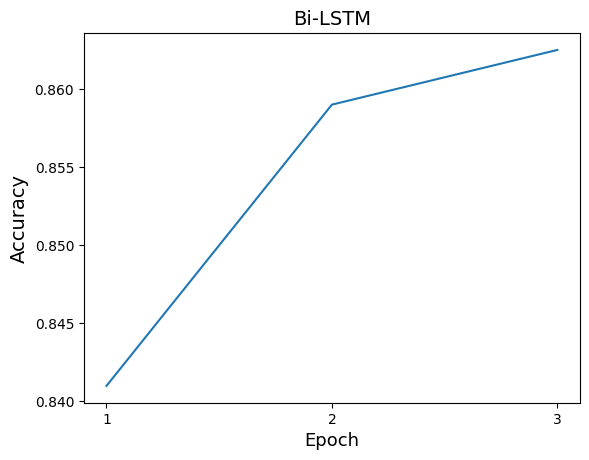

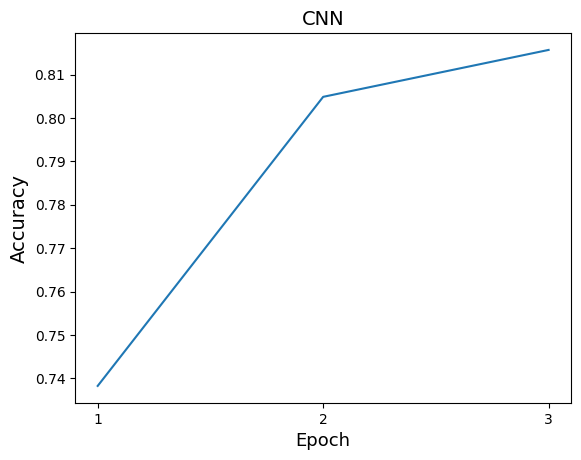

In [ ]:
plt.plot(data[2]['history_lstm']['accuracy'])
plt.title('Bi-LSTM', fontsize =14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch' , fontsize=13)
plt.xticks(ticks = np.arange(0, 3, step=1),  labels =  np.arange(1, 4, step=1))
#plt.savefig( 'fill-with-path' ,bbox_inches='tight')
plt.show()

plt.plot(data[2]['history_cnn']['accuracy'])
plt.title('CNN', fontsize =14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch' , fontsize=13)
plt.xticks(ticks = np.arange(0, 3, step=1),  labels =  np.arange(1, 4, step=1))
#plt.savefig( 'fill-with-path' ,bbox_inches='tight')
plt.show()

***Hypnogram Comparison***

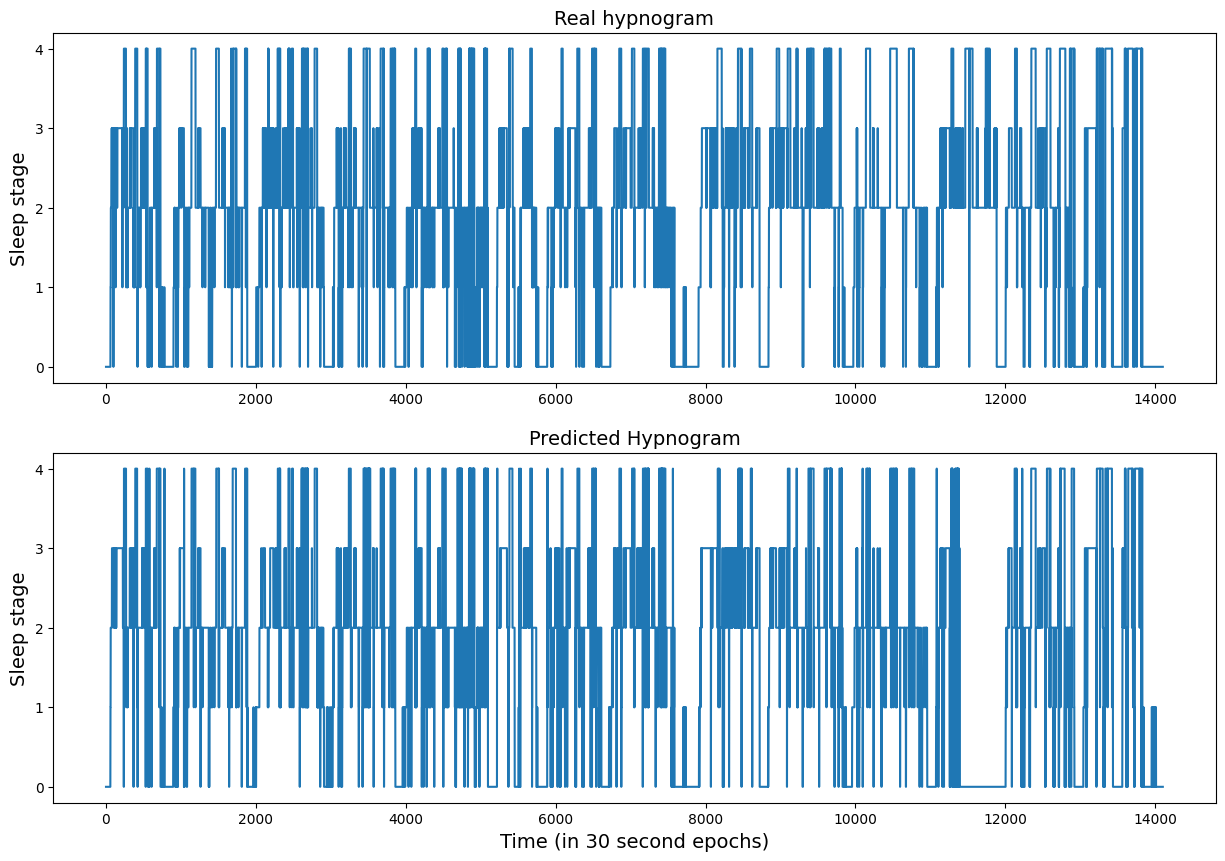

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = cv_results_attn[0]['y_pred']
y_test = cv_results_attn[0]['y_test']

# Increase the figure size to (width=15, height=10)
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

axs[0].set_title('Real hypnogram', size=14)
axs[0].set_ylabel('Sleep stage', fontsize=14)
axs[0].set_yticks([0, 1, 2, 3, 4])

axs[1].set_title('Predicted Hypnogram', size=14)
axs[1].set_ylabel('Sleep stage', fontsize=14)
axs[1].set_yticks([0, 1, 2, 3, 4])
axs[1].set_xlabel('Time (in 30 second epochs)', fontsize=14)

sns.lineplot(x=np.arange(len(y_test)), y=y_test, ax=axs[0])
sns.lineplot(x=np.arange(len(y_pred)), y=y_pred, ax=axs[1])

plt.show()

***Threshold Analysis***

In [ ]:
y_scores = []
y_preds = []
y_trues = []

for i in data:
  y_preds.extend(i['y_pred'])
  y_trues.extend(i['y_test'])
  y_scores.extend(i['y_prob'])

In [ ]:
scores = pd.Series(y_scores)
scores

0        [1.0, 2.105657e-14, 3.1861627e-15, 1.2977277e-...
1        [1.0, 6.148975e-20, 1.9923752e-22, 3.581227e-2...
2        [1.0, 1.05577515e-23, 1.06569355e-29, 1.674989...
3        [1.0, 1.3251786e-23, 3.4343056e-29, 6.6078534e...
4        [1.0, 2.157782e-23, 6.111764e-29, 1.6559556e-3...
                               ...                        
42303    [0.8942698, 0.103114635, 0.0013146125, 3.80374...
42304    [0.9997098, 0.00011591726, 6.090666e-06, 1.176...
42305    [0.99952316, 8.571865e-05, 3.903758e-05, 1.975...
42306    [0.9988192, 0.0011008502, 6.181823e-06, 4.3227...
42307    [0.99994063, 3.5612382e-05, 1.0753924e-06, 3.6...
Length: 42308, dtype: object

In [ ]:
scores = scores.apply(lambda x: max(x))
scores

0        1.000000
1        1.000000
2        1.000000
3        1.000000
4        1.000000
           ...   
42303    0.894270
42304    0.999710
42305    0.999523
42306    0.998819
42307    0.999941
Length: 42308, dtype: float32

<Axes: >

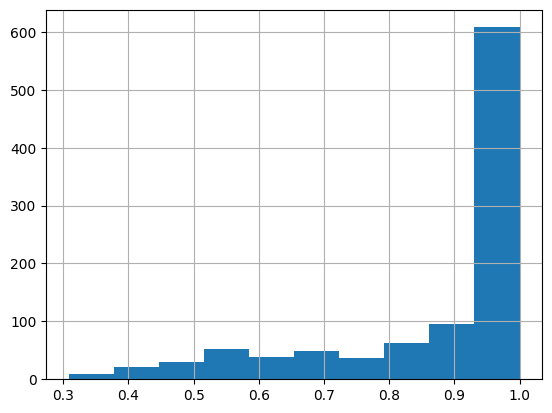

In [ ]:
scores.sample(n=1000).hist()

In [ ]:
""" It's evident that not all predictions were made with a y-score or probability of 1.0 (indicating total confidence).
This variability suggests that the model's confidence levels varied depending on the input data.
Consequently, it's advisable to establish a threshold to distinguish between 'confident' predictions and those with lower confidence, which may be more prone to errors.
The suggestion is that these less confident predictions undergo a detailed analysis by a human scorer. """

df = pd.DataFrame({'predicted':y_preds, 'true':y_trues, 'probs':scores })
df

,predicted,true,probs
0,0,0,1.000000
1,0,0,1.000000
2,0,0,1.000000
3,0,0,1.000000
4,0,0,1.000000
...,...,...,...
42303,0,0,0.894270
42304,0,0,0.999710
42305,0,0,0.999523
42306,0,0,0.998819


from matplotlib import pyplot as plt
df['predicted'].plot(kind='hist', bins=20, title='predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['true'].plot(kind='hist', bins=20, title='true')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['probs'].plot(kind='hist', bins=20, title='probs')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='predicted', y='true', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='true', y='probs', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['predicted'].plot(kind='line', figsize=(8, 4), title='predicted')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['true'].plot(kind='line', figsize=(8, 4), title='true')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['probs'].plot(kind='line', figsize=(8, 4), title='probs')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: >

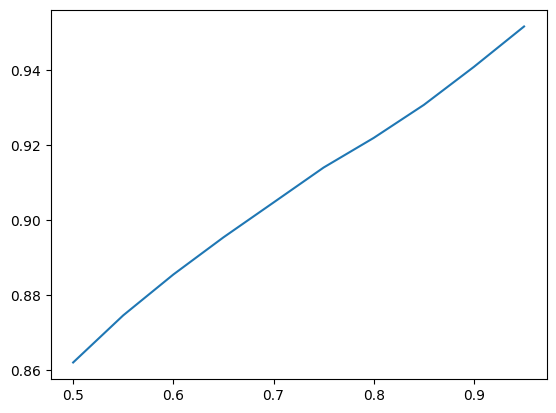

In [ ]:
acc_scores = []
ths = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for i in ths:
  dff = df[df.probs > i].reset_index()
  acc = accuracy_score(dff.true, dff.predicted)
  acc_scores.append(acc)

sns.lineplot(x=ths, y=acc_scores)

In [ ]:
total_size = df.shape[0]
print('Total size is: '+ str(total_size))

th = np.percentile(df.probs,20)  # change the percentile parameter to set percentage of epochs to filter out (5, 10, 20)
# print(th)
print('The threshold value is: ' + str(th)[0:5])
dff = df[df.probs > th].reset_index()
left = df[df.probs <= th].reset_index()

new_size = dff.shape[0]

print('New size is: '+ str(new_size))

print( str((total_size - new_size)) + ' sleep epochs were filtered out or discarded .\n')

print('The resulting classification report is: \n', classification_report(dff.true, dff.predicted, digits=4))

Total size is: 42308
The threshold value is: 0.758
New size is: 33846
8462 sleep epochs were filtered out or discarded .

The resulting classification report is: 
               precision    recall  f1-score   support

           0     0.8659    0.9853    0.9217      7135
           1     0.5963    0.1549    0.2460       839
           2     0.9554    0.9170    0.9358     14753
           3     0.9182    0.9194    0.9188      5127
           4     0.8980    0.9312    0.9143      5992

    accuracy                         0.9154     33846
   macro avg     0.8467    0.7816    0.7873     33846
weighted avg     0.9118    0.9154    0.9094     33846



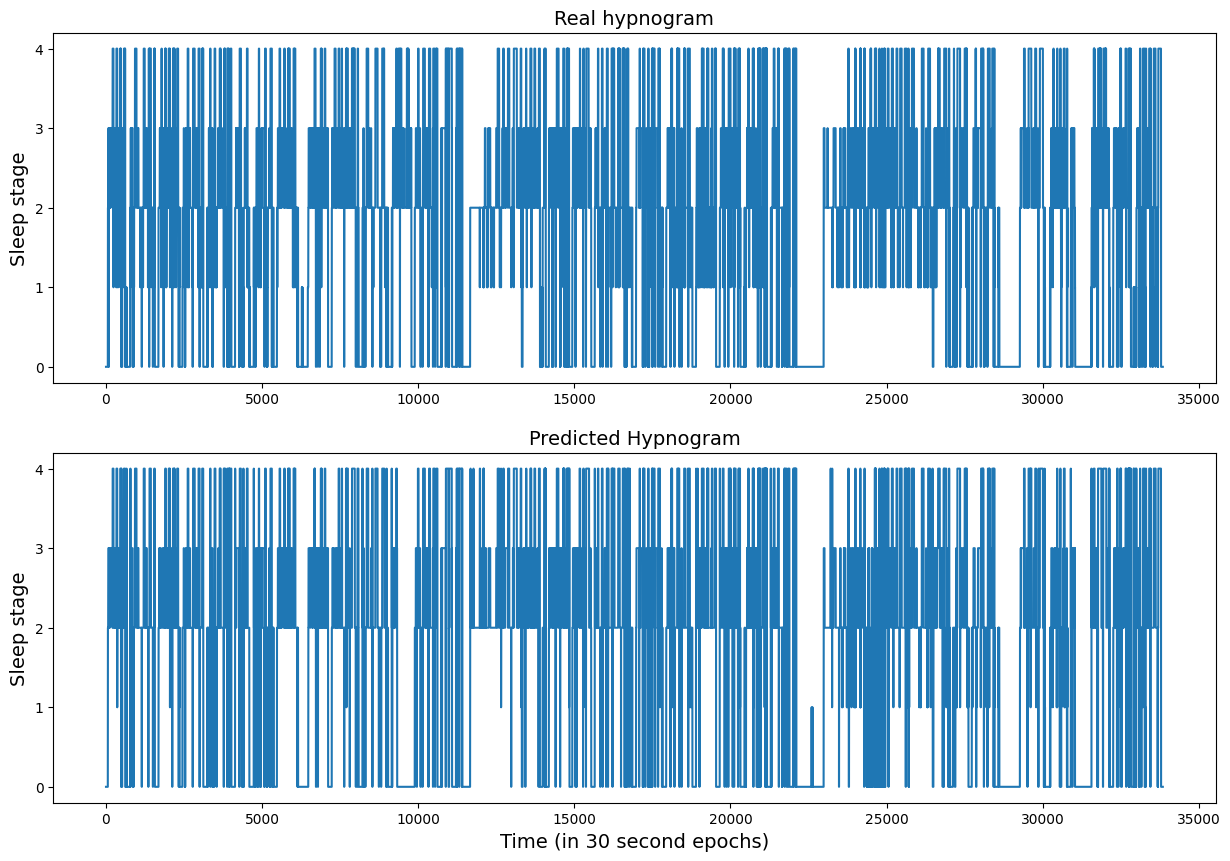

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = dff.predicted
y_test = dff.true

# Increase the figure size to (width=15, height=10)
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

axs[0].set_title('Real Hypnogram', size=14)
axs[0].set_ylabel('Sleep stage', fontsize=14)
axs[0].set_yticks([0, 1, 2, 3, 4])

axs[1].set_title('Predicted Hypnogram', size=14)
axs[1].set_ylabel('Sleep stage', fontsize=14)
axs[1].set_yticks([0, 1, 2, 3, 4])
axs[1].set_xlabel('Time (in 30 second epochs)', fontsize=14)


sns.lineplot(x=np.arange(len(y_test)), y=y_test, ax=axs[0])
sns.lineplot(x=np.arange(len(y_pred)), y=y_pred, ax=axs[1])

plt.show()

In [ ]:
import random
import datetime
path = '/content/gdrive/MyDrive/ML_projects/P2-sleep'
files = os.listdir(path)
filespath = []
for i in files:
  _, file_extension = os.path.splitext(i)
  # print(_)
  if file_extension.lower() == '.npz':
    # print(i)
    filespath.append(os.path.join(path, i))


def one_record_test_set(filespath,i):

  files = filespath[:]
  test_record = files.pop(i)
  print('Using record {} as test set'.format(test_record))

  X_test, y_test = load_npz_list_files([test_record])
  X_train, y_train = load_npz_list_files(files)

  print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

  return X_train, X_test, y_train, y_test, test_record

cv_results = []

# for i in range(1):
i =  -7 #we select this recording because it produces an accuracy score comparable to the general accuracy when trained with cross val
X_train, X_test, y_train, y_test, record = one_record_test_set(filespath, i)

begin_time_loop = datetime.datetime.now()
print('Current time: {}'.format(str(begin_time_loop)))

  #CNN
model = dual_cnn()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history1 = model.fit(X_train, y_train,
                  batch_size=100,
                  epochs=15, verbose=0) # 24



# Get feature vectors
layer_name = 'concat1' # holds the name of the intermediate layer from which we want to extract feature vectors.
intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output) # This function is used to create a new Keras model (intermediate_layer_model) that shares the same input as the original model (model) but produces the output of the specified intermediate layer ('concat')
intermediate_output_train = intermediate_layer_model.predict(X_train)
intermediate_output_test = intermediate_layer_model.predict(X_test)

# Ensure the shape is compatible with the LSTM input
a = np.zeros((1, 2688))

X_train_lstm = np.insert(intermediate_output_train, [0, 0, -1, -1], a, axis=0)
X_test_lstm = np.insert(intermediate_output_test, [0, 0, -1, -1], a, axis=0)

X_train_lstm2 = [X_train_lstm[i - 2:i + 3] for i in range(2, len(X_train_lstm) - 2)]
X_test_lstm2 = [X_test_lstm[i - 2:i + 3] for i in range(2, len(X_test_lstm) - 2)]

X_train_lstm3 = np.array(X_train_lstm2)
X_test_lstm3 = np.array(X_test_lstm2)

attn_bi_lstm = attn_bi_lstm_model()
attn_bi_lstm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history2 = attn_bi_lstm.fit(X_train_lstm3, y_train, batch_size=100, epochs=5, verbose=0)

test_scores = attn_bi_lstm.evaluate(X_test_lstm3, y_test, verbose=1)
print('Test accuracy:', test_scores[1])

y_prob = attn_bi_lstm.predict(X_test_lstm3)

y_pred = y_prob.argmax(axis=-1)

elapsed = dt.now() - begin_time_loop


fold_result = {
    'time': elapsed,
    'y_test': y_test,
    'y_pred': y_pred,
    'y_prob': y_prob,
    'history_cnn': history1.history,
    'history_lstm': history2.history,
    'accuracy': test_scores[1]
}

cv_results.append(fold_result)

Using record /content/gdrive/MyDrive/ML_projects/P2-sleep/SC4122E0.npz as test set
(977, 3000, 1) (977,) (41331, 3000, 1) (41331,)
Current time: 2024-03-12 10:52:16.620417
31/31 [==============================] - 2s 11ms/step - loss: 0.5910 - accuracy: 0.8219
Test accuracy: 0.8219037652015686
31/31 [==============================] - 2s 11ms/step


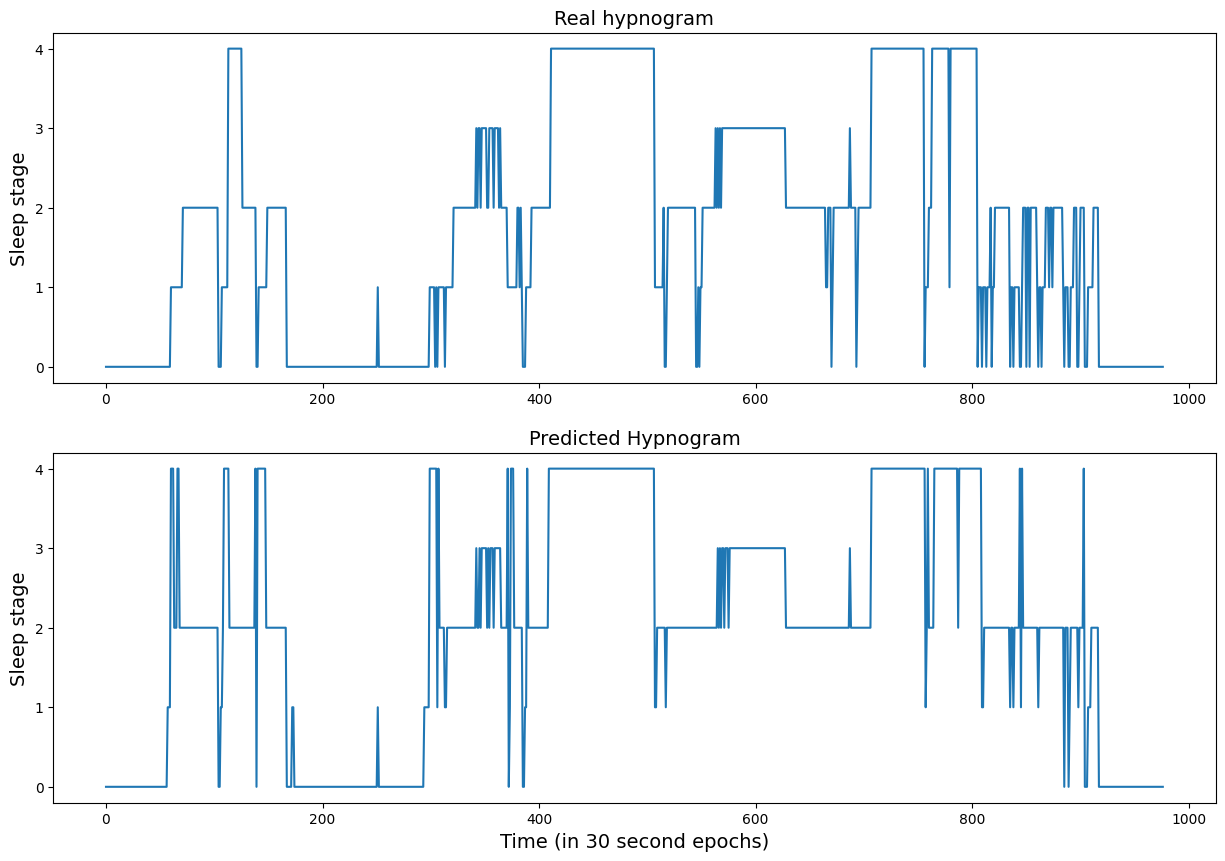

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = cv_results[0]['y_pred']
y_test = cv_results[0]['y_test']

# Increase the figure size to (width=15, height=10)
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

axs[0].set_title('Real hypnogram', size=14)
axs[0].set_ylabel('Sleep stage', fontsize=14)
axs[0].set_yticks([0, 1, 2, 3, 4])

axs[1].set_title('Predicted Hypnogram', size=14)
axs[1].set_ylabel('Sleep stage', fontsize=14)
axs[1].set_yticks([0, 1, 2, 3, 4])
axs[1].set_xlabel('Time (in 30 second epochs)', fontsize=14)

sns.lineplot(x=np.arange(len(y_test)), y=y_test, ax=axs[0])
sns.lineplot(x=np.arange(len(y_pred)), y=y_pred, ax=axs[1])

plt.show()

In [ ]:
import pickle

path = '/content/gdrive/MyDrive/ML_projects/P2-sleep/one_data_cnn_att.pkl'

with open(path, 'wb') as f:
    pickle.dump(cv_results, f)

# unravel y_pred and y_test into unique vectors for classification report
y_pred=[]
y_test=[]
for i in cv_results:
  y_pred.extend(i['y_pred'])
  y_test.extend(i['y_test'])

print(classification_report(y_test,y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9960    0.8655    0.9262       290
           1     0.3529    0.0992    0.1548       121
           2     0.7261    0.9791    0.8338       287
           3     0.9740    0.9375    0.9554        80
           4     0.8106    0.9246    0.8638       199

    accuracy                         0.8219       977
   macro avg     0.7719    0.7612    0.7468       977
weighted avg     0.7975    0.8219    0.7932       977



In [ ]:
import pickle

file_path = '/content/gdrive/MyDrive/ML_projects/P2-sleep/one_data_cnn_att.pkl'

try:
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    # After successful loading, you can work with the data in 'd'.
except EOFError:
    print("The file is empty or corrupted.")
except FileNotFoundError:
    print(f"No file found at {file_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
y_scores = []
y_preds = []
y_trues = []

for i in data:
  y_preds.extend(i['y_pred'])
  y_trues.extend(i['y_test'])
  y_scores.extend(i['y_prob'])

In [ ]:
scores = pd.Series(y_scores)
scores

0      [0.9999603, 5.2743444e-06, 8.796448e-06, 4.861...
1      [0.99921584, 0.00073514093, 2.6414893e-05, 3.8...
2      [0.9999945, 4.6833206e-06, 4.2889982e-07, 1.88...
3      [0.9818586, 0.018049553, 7.239708e-05, 7.30324...
4      [0.9999732, 2.658189e-05, 1.5314183e-07, 4.801...
                             ...                        
972    [1.0, 3.6884133e-12, 7.994917e-11, 3.030903e-1...
973    [0.99999964, 6.724857e-08, 2.6206882e-07, 1.26...
974    [0.9999999, 1.5235402e-09, 6.969737e-08, 4.975...
975    [0.99986017, 9.313021e-05, 3.8909107e-05, 7.03...
976    [0.94591874, 0.052007012, 0.0015198848, 0.0004...
Length: 977, dtype: object

In [ ]:
scores = scores.apply(lambda x: max(x))
scores

0      0.999960
1      0.999216
2      0.999995
3      0.981859
4      0.999973
         ...   
972    1.000000
973    1.000000
974    1.000000
975    0.999860
976    0.945919
Length: 977, dtype: float32

<Axes: >

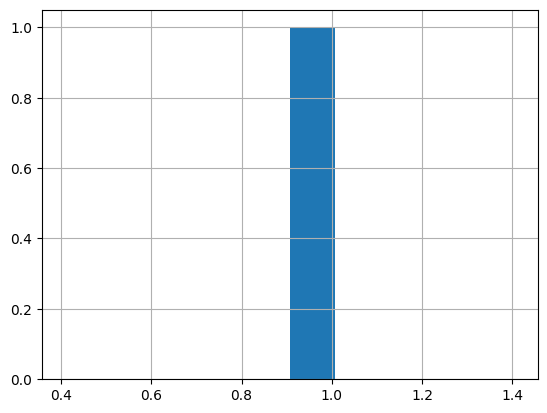

In [ ]:
scores.sample(n=1).hist()

In [ ]:
""" It's evident that not all predictions were made with a y-score or probability of 1.0 (indicating total confidence).
This variability suggests that the model's confidence levels varied depending on the input data.
Consequently, it's advisable to establish a threshold to distinguish between 'confident' predictions and those with lower confidence, which may be more prone to errors.
The suggestion is that these less confident predictions undergo a detailed analysis by a human scorer. """

df = pd.DataFrame({'predicted':y_preds, 'true':y_trues, 'probs':scores })
df

,predicted,true,probs
0,0,0,0.999960
1,0,0,0.999216
2,0,0,0.999995
3,0,0,0.981859
4,0,0,0.999973
...,...,...,...
972,0,0,1.000000
973,0,0,1.000000
974,0,0,1.000000
975,0,0,0.999860


<Axes: >

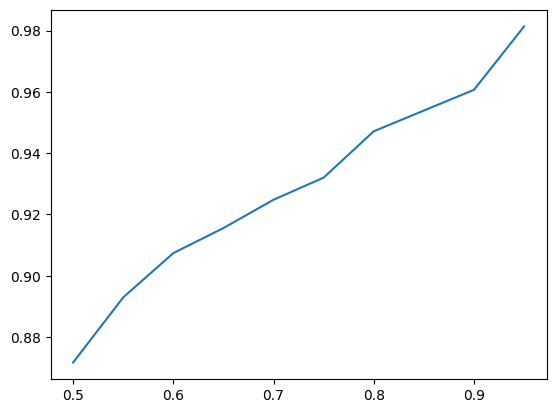

In [ ]:
acc_scores = []
ths = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for i in ths:
  dff = df[df.probs > i].reset_index()
  acc = accuracy_score(dff.true, dff.predicted)
  acc_scores.append(acc)

sns.lineplot(x=ths, y=acc_scores)

In [ ]:
total_size = df.shape[0]
print('Total size is: '+ str(total_size))

th = np.percentile(df.probs,20)  # change the percentile parameter to set percentage of epochs to filter out (5, 10, 20)
# print(th)
print('The threshold value is: ' + str(th)[0:5])
dff = df[df.probs > th].reset_index()
left = df[df.probs <= th].reset_index()

new_size = dff.shape[0]

print('New size is: '+ str(new_size))

print( str((total_size - new_size)) + ' sleep epochs were filtered out or discarded .\n')

print('The resulting classification report is: \n', classification_report(dff.true, dff.predicted, digits=4))

Total size is: 977
The threshold value is: 0.729
New size is: 781
196 sleep epochs were filtered out or discarded .

The resulting classification report is: 
               precision    recall  f1-score   support

           0     1.0000    0.9866    0.9933       224
           1     1.0000    0.0263    0.0513        38
           2     0.8387    0.9886    0.9075       263
           3     0.9855    0.9714    0.9784        70
           4     0.9667    0.9355    0.9508       186

    accuracy                         0.9270       781
   macro avg     0.9582    0.7817    0.7763       781
weighted avg     0.9364    0.9270    0.9071       781



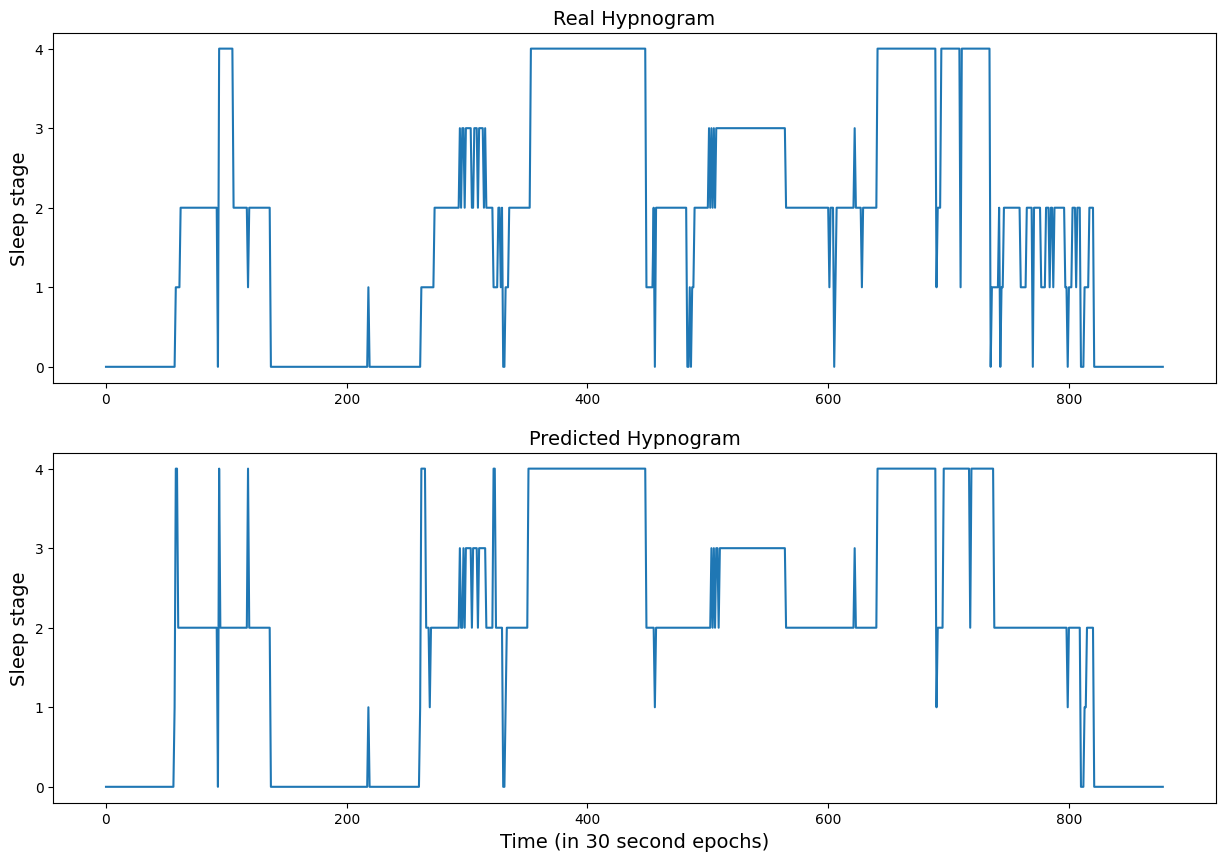

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = dff.predicted
y_test = dff.true

# Increase the figure size to (width=15, height=10)
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

axs[0].set_title('Real Hypnogram', size=14)
axs[0].set_ylabel('Sleep stage', fontsize=14)
axs[0].set_yticks([0, 1, 2, 3, 4])

axs[1].set_title('Predicted Hypnogram', size=14)
axs[1].set_ylabel('Sleep stage', fontsize=14)
axs[1].set_yticks([0, 1, 2, 3, 4])
axs[1].set_xlabel('Time (in 30 second epochs)', fontsize=14)


sns.lineplot(x=np.arange(len(y_test)), y=y_test, ax=axs[0])
sns.lineplot(x=np.arange(len(y_pred)), y=y_pred, ax=axs[1])

plt.show()

Text(0.5, 47.7222222222222, 'Predicted labels')

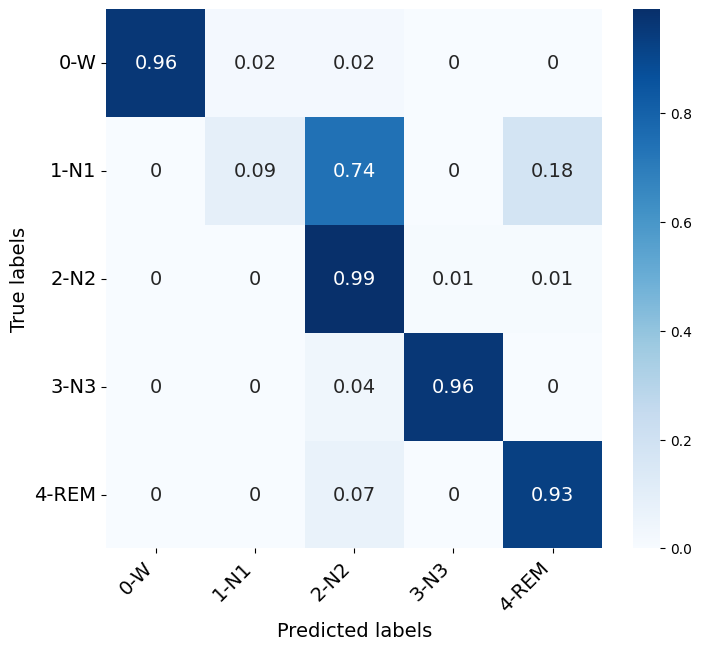

In [ ]:
C = confusion_matrix(y_test, y_pred)
cn = np.transpose(np.transpose(C) / C.astype(float).sum(axis=1))  # Use Python's built-in float
cn = np.round(cn, 2)

df_cm = pd.DataFrame(
    cn, index=['0-W', '1-N1', '2-N2', '3-N3', '4-REM'], columns=['0-W', '1-N1', '2-N2', '3-N3', '4-REM']
)
fig = plt.figure(figsize=(8, 7))
try:
    heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 14})
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.xlabel('Predicted labels', fontsize=14)


In [ ]:
# Attention block definition
def attention_block(inputs):
    # Project inputs to a query space
    query = layers.Dense(128, activation='tanh')(inputs)
    # Calculate attention scores using a softmax activation
    attention_scores = layers.Dense(1, activation='softmax', kernel_initializer='glorot_uniform')(query)
    # Multiply inputs by attention scores to get context vector
    context_vector = layers.multiply([inputs, attention_scores])
    # Sum over the time steps to get a single vector per sample
    context_vector = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)
    # Expand dimensions to match expected shape for the next layers
    context_vector = tf.expand_dims(context_vector, axis=1)
    return context_vector

# Main model definition
def attn_bi_lstm_model():
    # Define the input layer with the shape of (5, 2688)
    inputs = keras.Input(shape=(5, 2688))

    # Initial dropout to prevent overfitting
    x = layers.Dropout(rate=0.3)(inputs)

    # First Bidirectional LSTM layer with 128 units, returning sequences
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    # Dropout for regularization
    x = layers.Dropout(rate=0.3)(x)

    # Apply the attention mechanism to the output of the first Bidirectional LSTM layer
    x_attention = attention_block(x)

    # Second Bidirectional LSTM layer with 128 units
    x = layers.Bidirectional(layers.LSTM(128))(x_attention)
    # Dropout for regularization
    x = layers.Dropout(rate=0.5)(x)

    # Residual connection: Dense layer processing the original input
    x2 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
    # Batch normalization for training stability
    x2 = layers.BatchNormalization()(x2)
    # ReLU activation
    x2 = layers.ReLU()(x2)

    # Flatten the residual output
    x2 = layers.Flatten()(x2)

    # Combine the output of the LSTM layer with the residual connection
    x = layers.Concatenate()([x, x2])
    # Batch normalization for training stability
    x = layers.BatchNormalization()(x)
    # ReLU activation
    x = layers.ReLU()(x)

    # Final dropout layer for regularization
    x = layers.Dropout(rate=0.5)(x)
    # Fully connected layer with 256 units
    x = layers.Dense(256, activation='relu')(x)
    # Dropout for regularization
    x = layers.Dropout(rate=0.5)(x)

    # Output layer with 5 units (for 5 sleep stages) and softmax activation
    outputs = layers.Dense(5, activation='softmax')(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs, name='attn_bi_lstm_sleep')

    return model

In [ ]:
# Function to perform training and prediction for 20 stratified folds
def train_and_predict_attn(X, Y, n_splits=3):
  skf = StratifiedKFold(n_splits=n_splits)
  cv_results = []
  k = 0

  for train_index, test_index in skf.split(X, Y):
      begin_time_loop = dt.now()
      # print('Current time: {}'.format(str(begin_time_loop)))

      k = k + 1
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = Y[train_index], Y[test_index]

      # CNN
      model = dual_cnn()
      model.compile(
          loss=keras.losses.SparseCategoricalCrossentropy(),
          optimizer=keras.optimizers.Adam(learning_rate=0.001),
          metrics=['accuracy']
      )

      history1 = model.fit(X_train, y_train, batch_size=100, epochs= 10, verbose=0)

      # Get feature vectors
      layer_name = 'concat1' # holds the name of the intermediate layer from which we want to extract feature vectors.
      intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output) # This function is used to create a new Keras model (intermediate_layer_model) that shares the same input as the original model (model) but produces the output of the specified intermediate layer ('concat')
      intermediate_output_train = intermediate_layer_model.predict(X_train)
      intermediate_output_test = intermediate_layer_model.predict(X_test)

      # Ensure the shape is compatible with the LSTM input
      a = np.zeros((1, 2688))

      X_train_lstm = np.insert(intermediate_output_train, [0, 0, -1, -1], a, axis=0)
      X_test_lstm = np.insert(intermediate_output_test, [0, 0, -1, -1], a, axis=0)

      X_train_lstm2 = [X_train_lstm[i - 2:i + 3] for i in range(2, len(X_train_lstm) - 2)]
      X_test_lstm2 = [X_test_lstm[i - 2:i + 3] for i in range(2, len(X_test_lstm) - 2)]

      X_train_lstm3 = np.array(X_train_lstm2)
      X_test_lstm3 = np.array(X_test_lstm2)

      # attn_bi_lstm
      attn_bi_lstm = attn_bi_lstm_model()
      attn_bi_lstm.compile(
          loss=keras.losses.SparseCategoricalCrossentropy(),
          optimizer=keras.optimizers.Adam(learning_rate=0.001),
          metrics=['accuracy']
      )

      history2 = attn_bi_lstm.fit(X_train_lstm3, y_train, batch_size=100, epochs=5, verbose=0)

      test_scores = attn_bi_lstm.evaluate(X_test_lstm3, y_test, verbose=1)
      print('Test accuracy:', test_scores[1])

      y_prob = attn_bi_lstm.predict(X_test_lstm3)

      y_pred = y_prob.argmax(axis=-1)

      elapsed = dt.now() - begin_time_loop
      print('Fold {} took {}'.format(str(k), str(elapsed)))

      fold_result = {
          'fold': k,
          'time': elapsed,
          'y_test': y_test,
          'y_pred': y_pred,
          'y_prob': y_prob,
          'history_cnn': history1.history,
          'history_attn_bi_lstm': history2.history,
          'accuracy': test_scores[1]
      }

      cv_results.append(fold_result)

  return cv_results


In [ ]:
cv_results_attn = train_and_predict_attn(x, y, n_splits=3)

441/441 [==============================] - 4s 6ms/step - loss: 0.8780 - accuracy: 0.8495
Test accuracy: 0.8494646549224854
441/441 [==============================] - 4s 7ms/step
Fold 1 took 0:02:33.372499
441/441 [==============================] - 4s 6ms/step - loss: 0.5141 - accuracy: 0.8522
Test accuracy: 0.8522300124168396
441/441 [==============================] - 5s 8ms/step
Fold 2 took 0:02:26.153769
441/441 [==============================] - 5s 8ms/step - loss: 0.7173 - accuracy: 0.8182
Test accuracy: 0.8181818127632141
441/441 [==============================] - 4s 6ms/step
Fold 3 took 0:02:42.206496


In [ ]:
import pickle

path = '/content/gdrive/MyDrive/ML_projects/P2-sleep/dualcnn_attn_bilstm.pkl'

with open(path, 'wb') as f:
    pickle.dump(cv_results_attn, f)

# unravel y_pred and y_test into unique vectors for classification report
y_pred=[]
y_test=[]
for i in cv_results_attn:
  y_pred.extend(i['y_pred'])
  y_test.extend(i['y_test'])

print(classification_report(y_test,y_pred, digits=4))

In [ ]:
import pickle

file_path = '/content/gdrive/MyDrive/ML_projects/P2-sleep/dualcnn_bilstm.pkl'

try:
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    # After successful loading, you can work with the data in 'd'.
except EOFError:
    print("The file is empty or corrupted.")
except FileNotFoundError:
    print(f"No file found at {file_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")